This notebook is being used to test out some ideas on how to reproduce stochastic MDPs using principles from FastMDP:

https://lib.dr.iastate.edu/etd/17832/

This notebook assumes the reader has some familiarity with Markov Decision Processes and the Value Iteration algorithm.   An overview is provided, but there are many good textbooks and resources that explain MDPs more fully and more clearly.

*Note that to run this notebook on Colab, you will need to change the Runtime to a GPU runtime.  Depending on the amount of RAM used by the run, you may also find you need a Google Colab Pro account and run with the higher RAM option.*

# Preliminaries

In [185]:


import numpy as np
import operator


import matplotlib.pyplot as plt


import IPython.display as dp
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec 

import time

import numba as nb

from timeit import default_timer as timer

import networkx as nx

# Convolution (failed attempt)

Can we convolve the deterministic value function with a kernel to obtain the stochastic value function?


## Version 2 of code

In [186]:
#%load_ext autoreload
#%autoreload 2

#import os
#os.environ["NUMBA_ENABLE_CUDASIM"] = ""
#del os.environ["NUMBA_ENABLE_CUDASIM"]

import numpy as np
import math

import numba
from numba import cuda

@cuda.jit
def bellman_update_st(xmax, ymax, V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma):
    
    num_actions = T_gpu.shape[2]  # assumes 2-d state space definition

    x, y = cuda.grid( 2 )

    #print( "pos %d -> x %d, y %d" % (pos, x, y ) ) 
    if x >= xmax:
      return

    if y >= ymax:
      return


    # immediate reward
    r = R_gpu[ x, y ]

    # bellman update for stochastic mdp

    # first we have to compute the future expected value of taking
    # an action from this state.  We will keep track of the best
    # value we find in max_V.

    max_V = -np.inf

    # There is some additional parallelism we could take advantage of in here
    # if we'd like to kick off additional threads in parallel.  This will
    # get tricky because we'll need to either use atomic sum operations
    # or we'll need to build a pipeline of kernels to perform a reduction.
    # For now, performing the loop below on each thread, which will make
    # the algorithm slower than it could be on the GPU.
    for a in range(num_actions):

      # We have to sum up over all s' the expected future values
      V_sum = 0

      for xn in range(xmax):
        for yn in range(ymax):

          # probability of transitioning to the next state given
          # the current state and action
          P_n = T_gpu[ x, y, a, xn, yn ]

          # value of next state
          V_n = V_i[ xn, yn ]

          # expected future value of this transition
          V_sum += P_n * ( r + gamma * V_n )
      
      max_V = max( max_V, V_sum )

    # residual 
    res = abs(max_V - V_i[ x, y ])

    # update the value 
    V_o[ x, y ] = max_V

    # atomically update the residual
    cuda.atomic.max( residual_gpu, 0, res ) 
    


def numba_value_iteration_st(dims, V, T, R, epsilon, gamma):
    # Move data to GPU so we can do two operations on it
    V_gpu_a = cuda.to_device(V)
    V_gpu_b = cuda.to_device(V)
    T_gpu = cuda.to_device(T)
    R_gpu = cuda.to_device(R)

    num_actions = T.shape[2]

    residual = np.array( [ -np.inf ], dtype=V.dtype )

    start = timer()    

    count = 0
    while count == 0 or ( residual[0] > epsilon ):  # and count < 100 ):

      # Set up a ping-pong between the two value function buffers
      # so that V_i (input) is fixed during the iteration and
      # V_o (output) is updated at each iteration.
      if count % 2 == 0:
        V_i = V_gpu_a
        V_o = V_gpu_b
      else:
        V_i = V_gpu_b
        V_o = V_gpu_a

      # reset residual for next run
      residual[0] = -np.inf
    
      residual_gpu = cuda.to_device( residual )

      end1 = timer()

      num_threads = dims[0] * dims[1]
      threadsperblock = (16, 16)
      blockspergrid_x = math.ceil(dims[0] / threadsperblock[0])
      blockspergrid_y = math.ceil(dims[1] / threadsperblock[1])
      blockspergrid = (blockspergrid_x, blockspergrid_y)      

      ### Perform Bellman upate
      bellman_update_st[blockspergrid,threadsperblock](dims[0], dims[1], V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma)

      end2 = timer()

      residual = residual_gpu.copy_to_host()

      end3 = timer()

      #print( "count %d: %f - %f secs (%f + %f + %f)" % (count, residual[0], end3 - start, end1 - start, end2-end1, end3-end2) )
      start = end3

      #np.save( 'val_iter/hist_%d.npy' % count, V_gpu.copy_to_host() )

      count += 1 


    return V_o.copy_to_host()



In [187]:

def gen_nbrs(x,y, xmax, ymax):
    # up
    xu = x 
    yu = max( 0, y - 1 )

    # left
    xl = max( 0, x - 1 ) 
    yl = y

    # down
    xd = x 
    yd = min( ymax-1, y + 1 )

    # right
    xr = min( xmax-1, x + 1 ) 
    yr = y

    return [ [xu,yu],
             [xl,yl],
             [xd,yd],
             [xr,yr]
            ]

def gen_transition_function( bleed=0.1 ):

  # The transition function is T( s, a, s' ).
  T = np.zeros( (*dims, num_actions, *dims)  )


  print( "Building transition function" )

  assert bleed >= 0.0 and 4 * bleed < 1.0, "Becasue we have 4 actions, we can't have a bleed whose sum exceeds a probability of 1.0"

  # Here's how certain we are that we will transition to the intended state
  certainty = 1.0 - (4 * bleed)

  # Create a stochastic transition function for up, down, left, and right
  # where there is uncertainty in the resulting state
  xmax = ymax = dim
  for x in range(dim):
    for y in range(dim):

      nbr = gen_nbrs( x, y, xmax, ymax )

      # When we take an action, set a probability of 0.6 that we'll make it 
      # to the desired state
      for a, n in enumerate(nbr):
        xn, yn = n
        T[ x, y, a, xn, yn ] = certainty

        # And set a probability of 0.1 that we will end up one extra step
        # away from the expected state were this a deterministic MDP.  
        # This is a poor man's gaussian centered around the expected state.
        nbr2 = gen_nbrs( xn, yn, xmax, ymax )

        for n2 in nbr2:
          xn2, yn2 = n2 
          T[ x, y, a, xn2, yn2 ] = bleed
    
  return T
  

First lets define a determistic and a stochastic MDP transition function.


In [188]:
# The dimensions of the state space S is captured by dims.  
# Multiplying the dimensions together would yield the size of the
# state space |S|.
dim = 100
dims = (dim,dim)  # square grid world
size = np.prod( dims )


# Our action space is up, left, down, right.  If we were to go beyond
# the boundaries of the state space by taking an action 'a', then 
# will will just stay in the current state 's'.
num_actions = 4

print( dims, size )
T_det = gen_transition_function( 0.0 )
T_sto = gen_transition_function( 0.1 )



(100, 100) 10000
Building transition function
Building transition function


In [189]:


# The value function is the same size as the state space


# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

# define some rewards in the reward function
R[ 20,70 ] = 10
#R[ 90,30 ] = 10

# define bellman residual threshold
epsilon = .01

# discount factor
gamma = 0.99

print( "Solving MDP" )
V = np.zeros( dims )
V_det = numba_value_iteration_st( dims, V, T_det, R, epsilon, gamma )

V = np.zeros( dims )
V_sto = numba_value_iteration_st( dims, V, T_sto, R, epsilon, gamma )


Solving MDP


/home/bertrjr1/anaconda3/envs/gpu2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (49) < 2 * SM count (92) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/bertrjr1/anaconda3/envs/gpu2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (49) < 2 * SM count (92) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


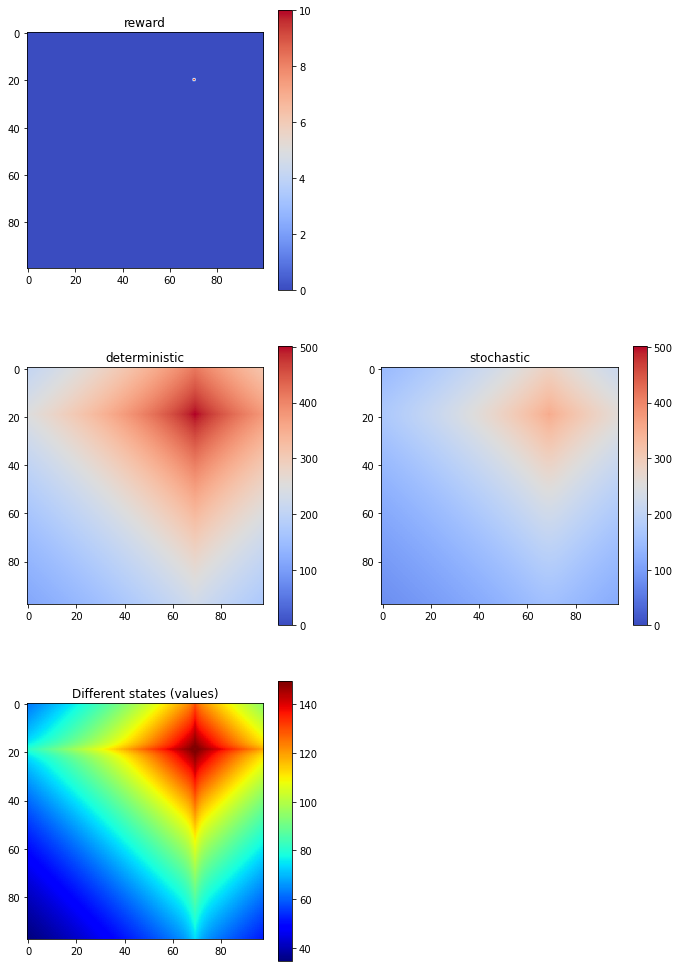

In [190]:


from timeit import default_timer as timer

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18,36), constrained_layout=False)
gs = fig.add_gridspec(6,3)



b= 0
bleed=0

ax = fig.add_subplot(gs[0, b])
plt.title( "reward" )
p = plt.imshow( R, cmap="coolwarm" )
plt.colorbar( p )

ax = fig.add_subplot(gs[1, b])
plt.title( "deterministic")
p = plt.imshow( V_det[1:-1,1:-1], cmap="coolwarm", vmin=V_det.min(), vmax=V_det.max() )
plt.colorbar( p )

ax = fig.add_subplot(gs[1, b+1])
plt.title( "stochastic")
p = plt.imshow( V_sto[1:-1,1:-1], cmap="coolwarm", vmin=V_det.min(), vmax=V_det.max() )
plt.colorbar( p )

# Now highlight all the states that are different as a mask
ax = fig.add_subplot(gs[2, b])
plt.title( "Different states (values)")
p = plt.imshow( (V_det - V_sto)[1:-1,1:-1] , cmap="jet" )
plt.colorbar(p )

# Now highlight all the states that are different as a mask
#ax = fig.add_subplot(gs[2, b+1])
#plt.title( "Different states (log-values)")
#p = plt.imshow( np.log(V_det - V_sto) , cmap="jet" )
#plt.colorbar(p )

# Now highlight all the states that are different as a mask.
# Note that floating point roundoff / underflow could create
# some false positives.
#ax = fig.add_subplot(gs[3, b])
#threshold = 1.0e-2
#plt.title( "Different states (mask at %f)" % threshold)
#mask = np.abs(V_det - V_sto) > threshold
#p = plt.imshow( mask, cmap="coolwarm" )
#plt.colorbar(p )



In [191]:
!pip install scipy
from scipy.ndimage import convolve

In [192]:
# Lets try to convolve V_det with some kernels to see if we can get V_sto.

if False:
  # This didn't work, not even close
  k = np.array([[0,.1,0],[.1,.6,.1],[0,.1,0]])
  V_con = convolve(V_det, k, mode='constant', cval=0.0)

if False:
  # This didn't work either but comes close to reconstructing the deterministic
  # value function (still a lot of error on the tails)
  V_con         =  0.6 * V_det
  V_con[1:,:]  +=  0.1 * V_det[:-1,:]
  V_con[:-1,:] +=  0.1 * V_det[1:,:]
  V_con[:,1:]  +=  0.1 * V_det[:,:-1]
  V_con[:,:-1] +=  0.1 * V_det[:,1:]

if False:
  # This didn't work either but comes close to reconstructing the deterministic
  # value function
  V_con         = 0.6 * V_det
  V_con[1:,:]  +=  gamma * 0.1 * V_det[:-1,:]
  V_con[:-1,:] +=  gamma * 0.1 * V_det[1:,:]
  V_con[:,1:]  +=  gamma * 0.1 * V_det[:,:-1]
  V_con[:,:-1] +=  gamma * 0.1 * V_det[:,1:]

if True:
  # This gets the roughly correct magnitude, but doesn't capture the major axes
  # very well.  Leaves grooves along the nsew axes for some reason.
  V_con         = .703 * V_det   # roughly 1/sqrt(2), connection?

if False:
  # This gets the roughly correct magnitude, but doesn't capture the major axes
  # very well.  Leaves grooves along the nsew axes for some reason.
  V_con         = .6 * V_det



if False:
  # This was a pretty dumb idea.  
  V_con         = np.zeros_like( V_det )

  for i in range(dims[0]):
    for j in range(dims[1]):

      print( i, j )
      for r in range(dims[0]):
        for s in range(dims[1]):

          dist = np.abs( i - r ) + np.abs( j - s )

          V_con[i,j] += 0.6 * gamma * V_det[r,s] 


if False:
  # Try to multiply by a gaussian?
  # e^(-(x - 0)^2/(2 100^2))/(sqrt(2 π) 5)
  V_con         = .6 * V_det

In [193]:
0.6 + 0.1* 0.6**2 * gamma  + 0.1 * 0.6**3 * gamma**2 + 0.1 * 0.6**4 * gamma **3

sum = 0.6
for i in range(4):
  sum += 0.1 * gamma
  if i % 1 == 0: print( sum )

print( 'r: ', 502.0234/353.4454 )

0.699
0.7979999999999999
0.8969999999999999
0.9959999999999999
r:  1.420370444770253


In [194]:
Vds = V_det.sum()

V_con.min(), V_con.max(), V_con.sum()/Vds, V_det.min(), V_det.max(), Vds/Vds, V_sto.min(), V_sto.max(), V_sto.sum()/Vds

(0.0,
 352.92246780863695,
 0.703,
 0.0,
 502.02342504784775,
 1.0,
 26.10834050261829,
 353.44545429555126,
 0.6971567538584414)

/tmp/ipykernel_29294/3422262045.py:49: RuntimeWarning: divide by zero encountered in log
  p = plt.imshow( np.log(V_con)[1:-1,1:-1] , cmap="jet" )


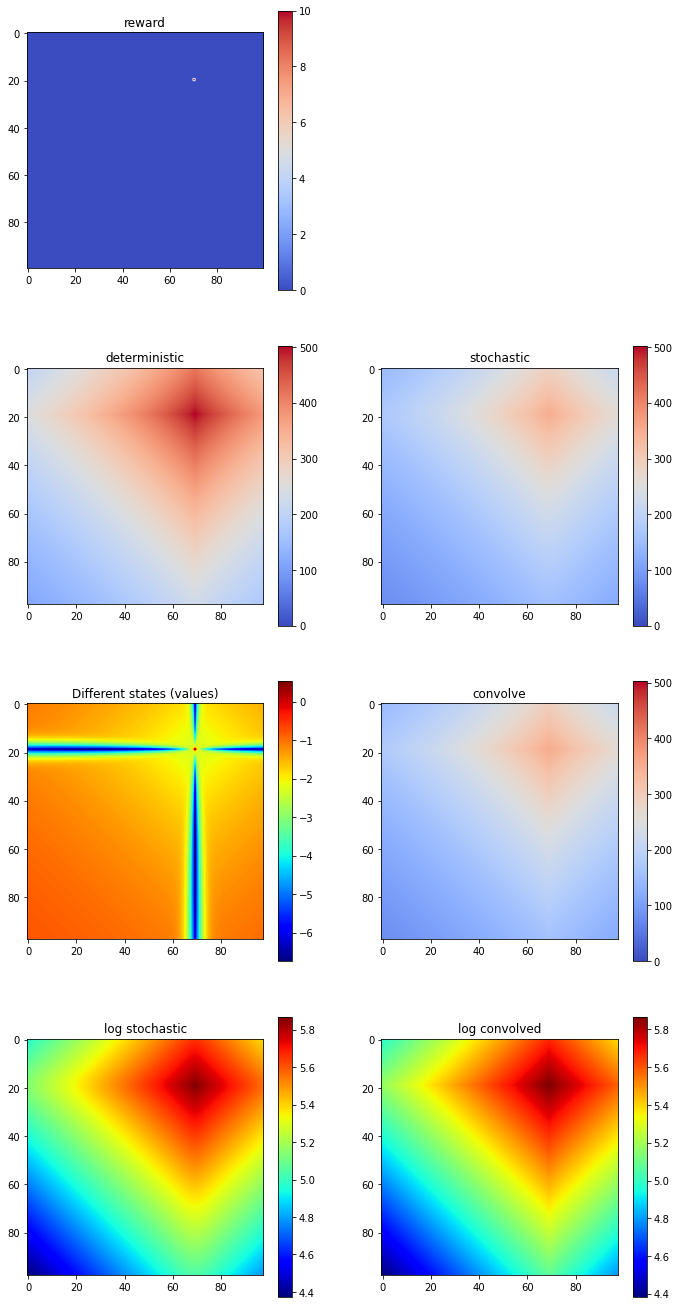

In [195]:


from timeit import default_timer as timer

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18,36), constrained_layout=False)
gs = fig.add_gridspec(6,3)



b= 0
bleed=0

ax = fig.add_subplot(gs[0, b])
plt.title( "reward" )
p = plt.imshow( R, cmap="coolwarm" )
plt.colorbar( p )

ax = fig.add_subplot(gs[1, b])
plt.title( "deterministic")
p = plt.imshow( V_det[1:-1,1:-1], cmap="coolwarm", vmin=V_det.min(), vmax=V_det.max() )
plt.colorbar( p )

ax = fig.add_subplot(gs[1, b+1])
plt.title( "stochastic")
p = plt.imshow( V_sto[1:-1,1:-1], cmap="coolwarm", vmin=V_det.min(), vmax=V_det.max() )
plt.colorbar( p )

ax = fig.add_subplot(gs[2, b+1])
plt.title( "convolve")
p = plt.imshow( V_con[1:-1,1:-1], cmap="coolwarm", vmin=V_det.min(), vmax=V_det.max() )
plt.colorbar( p )

# Now highlight all the states that are different as a mask
ax = fig.add_subplot(gs[2, b])
plt.title( "Different states (values)")
p = plt.imshow( (V_sto - V_con)[1:-1,1:-1] , cmap="jet" )
plt.colorbar(p )

# Now highlight all the states that are different as a mask
ax = fig.add_subplot(gs[3, b])
plt.title( "log stochastic")
p = plt.imshow( np.log(V_sto)[1:-1,1:-1] , cmap="jet" )
plt.colorbar(p )

# Now highlight all the states that are different as a mask
ax = fig.add_subplot(gs[3, b+1])
plt.title( "log convolved")
p = plt.imshow( np.log(V_con)[1:-1,1:-1] , cmap="jet" )
plt.colorbar(p )



So just a simple scaling can get us most of the way there, but there's obvious differences here along the major axes of the reward here.

# Second Try

This is the GPU version of the code from the graph notebook.  It does not assume a 2D grid world.  I want to study this for 1D grid worlds to see if it's easier to spot a method that will work.

## Graph Building

In [196]:
#%load_ext autoreload
#%autoreload 2

#import os
#os.environ["NUMBA_ENABLE_CUDASIM"] = ""
#del os.environ["NUMBA_ENABLE_CUDASIM"]

import numpy as np
import math

import numba
from numba import cuda

@cuda.jit
def bellman_update_st(xmax, V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma):
    
    num_actions = T_gpu.shape[1]  # assumes 1-d state space definition

    x = cuda.grid( 1 )

    #print( "pos %d -> x %d, y %d" % (pos, x, y ) ) 
    if x >= xmax:
      return


    # immediate reward
    r = R_gpu[ x ]

    # bellman update for stochastic mdp

    # first we have to compute the future expected value of taking
    # an action from this state.  We will keep track of the best
    # value we find in max_V.

    max_V = -np.inf

    # There is some additional parallelism we could take advantage of in here
    # if we'd like to kick off additional threads in parallel.  This will
    # get tricky because we'll need to either use atomic sum operations
    # or we'll need to build a pipeline of kernels to perform a reduction.
    # For now, performing the loop below on each thread, which will make
    # the algorithm slower than it could be on the GPU.
    for a in range(num_actions):

      # We have to sum up over all s' the expected future values
      V_sum = 0

      for xn in range(xmax):
        # probability of transitioning to the next state given
        # the current state and action
        P_n = T_gpu[ x, a, xn ]

        # value of next state
        V_n = V_i[ xn ]

        # expected future value of this transition
        V_sum += P_n * ( r + gamma * V_n )
      
      max_V = max( max_V, V_sum )

    # residual 
    res = abs(max_V - V_i[ x ])

    # update the value 
    V_o[ x ] = max_V

    # atomically update the residual
    cuda.atomic.max( residual_gpu, 0, res ) 
    


def numba_value_iteration_st(N, V, T, R, epsilon, gamma):
    # Move data to GPU so we can do two operations on it
    V_gpu_a = cuda.to_device(V)
    V_gpu_b = cuda.to_device(V)
    T_gpu = cuda.to_device(T)
    R_gpu = cuda.to_device(R)

    num_actions = T.shape[1]

    residual = np.array( [ -np.inf ], dtype=V.dtype )

    start = timer()    

    count = 0
    while count == 0 or ( residual[0] > epsilon ):  # and count < 100 ):

      # Set up a ping-pong between the two value function buffers
      # so that V_i (input) is fixed during the iteration and
      # V_o (output) is updated at each iteration.
      if count % 2 == 0:
        V_i = V_gpu_a
        V_o = V_gpu_b
      else:
        V_i = V_gpu_b
        V_o = V_gpu_a

      # reset residual for next run
      residual[0] = -np.inf
    
      residual_gpu = cuda.to_device( residual )

      end1 = timer()

      num_threads = N
      threadsperblock = 256
      blockspergrid_x = math.ceil(N / threadsperblock)
      blockspergrid = blockspergrid_x     

      ### Perform Bellman upate
      bellman_update_st[blockspergrid,threadsperblock](N, V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma)

      end2 = timer()

      residual = residual_gpu.copy_to_host()

      end3 = timer()

      #print( "count %d: %f - %f secs (%f + %f + %f)" % (count, residual[0], end3 - start, end1 - start, end2-end1, end3-end2) )
      start = end3

      #np.save( 'val_iter/hist_%d.npy' % count, V_gpu.copy_to_host() )

      count += 1 


    return V_o.copy_to_host()



In [197]:



import numpy as np
import operator


import matplotlib as mpl
import matplotlib.pyplot as plt


import IPython.display as dp
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec 

import time

import numba as nb

from timeit import default_timer as timer


import networkx as nx



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


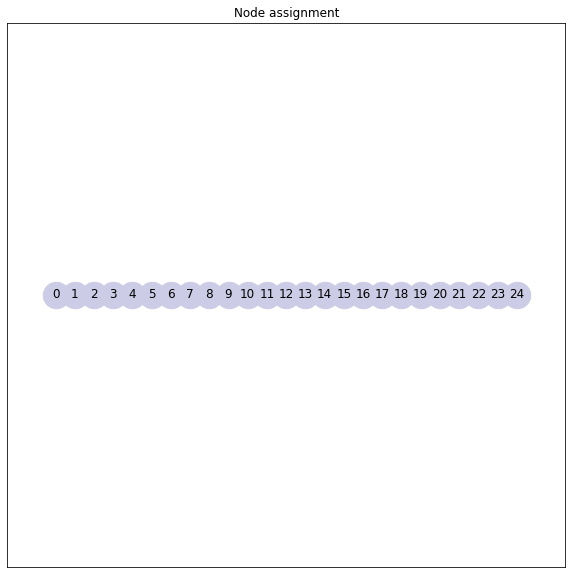

In [198]:
# Generate a 1D grid world using networkx to do it.
G = nx.generators.random_graphs.random_lobster( 20, .0, .1, seed=5)

#pos=nx.spring_layout(G,iterations=100)

nodes = np.array( list(G.nodes) )

N = len(nodes)
o = np.ones( N )

xscale = 50
pos={}
for i in range(N):
  pos[i] = np.array([ i * xscale, 0 ])


sz = 700

figsize = (10,10) 

plt.figure(figsize=figsize)
plt.title( "Node assignment" )

edge_colors= np.c_[ [ .8 * o, .8 * o, .9 * o, .7 * o ] ].T
nx.draw_networkx(G, pos,  node_size=sz, node_color=(.8, .8, .9, 1.0), edge_color=edge_colors, with_labels=True)


In [199]:

# Instead generate a dictionary with key of the node and value of a list of 
# outgoing nodes
edges = {}
for edge in list(G.edges):
  #print( edge, type(edge) )
  src, dst = edge

  # Generate from src to dst
  try:
    edges[src] += [ dst ]
  except KeyError:
    edges[src] = [ dst ]

  # And since this is a undirected graph generate the reverse transition
  try:
    edges[dst] += [ src ]
  except KeyError:
    edges[dst] = [ src ]

# Determine the maximum number of outgoing transitions from any node
max_out_degree = -1
for src, outgoing in edges.items():
  max_out_degree = max( max_out_degree, len(outgoing) )

print( 'edges: ', edges )
print( 'max_out_degree: ', max_out_degree )



edges:  {0: [1], 1: [0, 2], 2: [1, 3], 3: [2, 4], 4: [3, 5], 5: [4, 6], 6: [5, 7], 7: [6, 8], 8: [7, 9], 9: [8, 10], 10: [9, 11], 11: [10, 12], 12: [11, 13], 13: [12, 14], 14: [13, 15], 15: [14, 16], 16: [15, 17], 17: [16, 18], 18: [17, 19], 19: [18, 20], 20: [19, 21], 21: [20, 22], 22: [21, 23], 23: [22, 24], 24: [23]}
max_out_degree:  2


## Deterministic Case

In [200]:

# Generate a transition function from an undirected graph
# We assume that transitions to and from the connected nodes
# are possible and correspond to an action that is available
# from both nodes.  We also assume this transition is deterministic.
# We assume that all nodes are connected -- that they have at least
# one incoming/outgoing edge.  

def gen_transition_function(N, edges, max_out_degree):

  # The transition function is T( s, a, s' ).  We assume that there is an
  # ordered list of edges from each node.  We assume that there is at least
  # one outgoing edge from each node.  We assign the actions $a \in {0, 1, \cdots}$ 
  # to that ordered list of edges.  If a node k has an outgoing degree of D, then
  # only that many actions are defined for that node $a_k \in {0, \cdots, D}$.
  # We assume a maximum outgoing degree which is supplied by the caller.  This 
  # allows us to create a regular rectangular ND-array, though it will be an 
  # inefficient representation because there will be so many unnecessary zeros 
  # in it.  As an optimization for the future, could represent it as a sparse 
  # array to minimize the amount of memory consumed by the array.
  T = np.zeros( (N, max_out_degree, N)  )


  print( "Building transition function" )
  
  # Extract s, a, sp (s-prime) from the edges
  for s, outgoing in edges.items():

    for a, sp in enumerate(outgoing):

      # Assume a deterministic transition
      T[ s, a, sp ] = 1.0
    
  return T
  

In [201]:
T = gen_transition_function( N, edges, max_out_degree )
T_det = T  # give it an alias that we can refer back to once we look at the stochastic transition function

Building transition function


In [202]:
# Let's create a reward function defined over the graph

R = np.zeros( (N) )

# Put a reward at a random node in the graph.  I picked node
# a node arbitrarily and put a reward at that location.
R[int(N/2)] = 10

In [203]:


# define bellman residual threshold
epsilon = .00001

# discount factor
gamma = 0.9

print( "Solving MDP" )
V = np.zeros( (N) )
V_det = numba_value_iteration_st( N, V, T, R, epsilon, gamma )


Solving MDP


/home/bertrjr1/anaconda3/envs/gpu2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (92) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/bertrjr1/anaconda3/envs/gpu2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (92) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


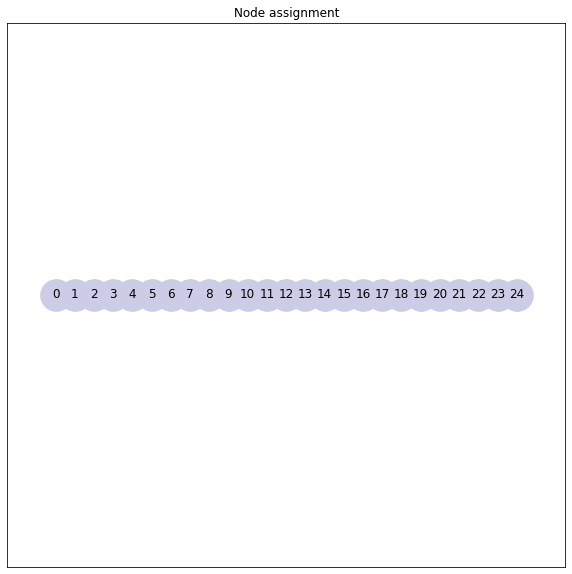

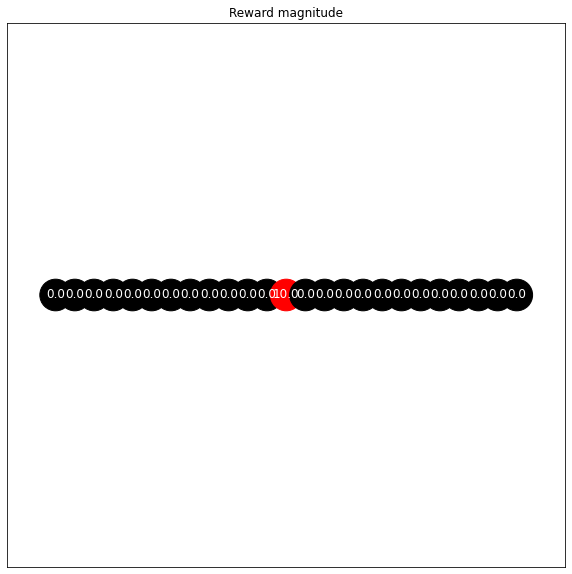

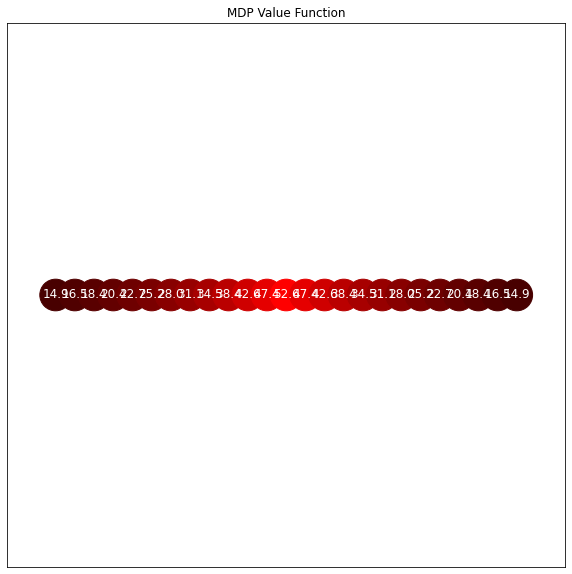

In [204]:
# How are we going to graph this?

sz = 1000

figsize = (10,10) 

#pos=nx.spring_layout(G,iterations=100)
plt.figure(figsize=figsize)
plt.title( "Node assignment" )
edge_colors= np.c_[ [ .8 * o, .8 * o, .9 * o, .7 * o ] ].T
nx.draw_networkx(G, pos,  node_size=sz, node_color=(.8, .8, .9, 1.0), edge_color=edge_colors, with_labels=True)


# Rewards
node_colors = np.c_[ R/R.max(), np.zeros( N ), np.zeros( N ) ]
cmap = plt.cm.coolwarm

plt.figure(figsize=figsize)
plt.title( "Reward magnitude" )

o = np.ones( N )
edge_colors= np.c_[ [ .8 * o, .8 * o, .9 * o, .7 * o ] ].T
n = nx.draw_networkx_nodes(G, pos,  node_size=sz, node_color=node_colors, cmap=cmap)
e = nx.draw_networkx_edges(G, pos,  node_size=sz, edge_color=edge_colors)
label_options = {"ec": "k", "fc": "white", "alpha": 0.0}
reward_labels = {}
for i in range(N):
  reward_labels[i] = R[i]

l = nx.draw_networkx_labels(G, pos, labels=reward_labels, font_color='white', font_size=12, bbox=label_options)


# Value
col = V_det/V_det.max() 
node_colors = np.c_[ col , 0*col, 0*col]
cmap = plt.cm.coolwarm

plt.figure(figsize=figsize)
plt.title( "MDP Value Function" )

n = nx.draw_networkx_nodes(G, pos,  node_size=sz, node_color=node_colors, cmap=cmap)
e = nx.draw_networkx_edges(G, pos,  node_size=sz, edge_color=[.8,.8,.9,.7])
label_options = {"ec": "k", "fc": "white", "alpha": 0.0}
labels = {}
for i in range(N):
  labels[i] = f'%.1f' % V_det[i]

l = nx.draw_networkx_labels(G, pos, labels=labels, font_color='white', font_size=12, bbox=label_options)



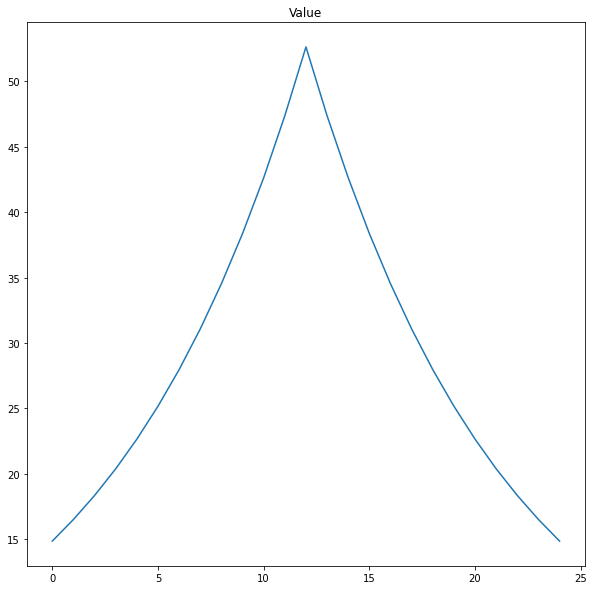

In [205]:
# How are we going to graph this?

sz = 1000

figsize = (10,10) 

#pos=nx.spring_layout(G,iterations=100)
plt.figure(figsize=figsize)
plt.title( "Value" )

x = np.arange( N )
plt.plot( x, V_det )



## Stochastic Case

Now need to make the stochastic version of this


In [206]:

# Generate a transition function for our 1D world

def gen_deterministic_transition_function(N, max_out_degree):

  T = np.zeros( (N, max_out_degree, N)  )

  print( "Building transition function" )
  
  for s in range(N):

    if s == 0:
      a = 0 # right
      sp = 1
      T[ s, a, sp   ] = 1.0
    elif s == N-1:
      a = 0 # left
      sp = N-2
      T[ s, a, sp   ] = 1.0
    elif s == 1:
      a = 0 # left
      sp = 0
      T[ s, a, sp   ] = 1.0
      a = 1 # right
      sp = 2
      T[ s, a, sp   ] = 1.0
    elif s == N-2:
      a = 0 # left
      sp = N-3
      T[ s, a, sp   ] = 1.0
      a = 1 # right
      sp = N-1
      T[ s, a, sp   ] = 1.0
    else:
      a = 0 # left
      sp = s-1
      T[ s, a, sp   ] = 1.0
      a = 1 # right
      sp = s+1
      T[ s, a, sp   ] = 1.0

    
  return T
  

def gen_stochastic_transition_function(N, max_out_degree):

  # The transition function is T( s, a, s' ).  We assume that there is an
  # ordered list of edges from each node.  We assume that there is at least
  # one outgoing edge from each node.  We assign the actions $a \in {0, 1, \cdots}$ 
  # to that ordered list of edges.  If a node k has an outgoing degree of D, then
  # only that many actions are defined for that node $a_k \in {0, \cdots, D}$.
  # We assume a maximum outgoing degree which is supplied by the caller.  This 
  # allows us to create a regular rectangular ND-array, though it will be an 
  # inefficient representation because there will be so many unnecessary zeros 
  # in it.  As an optimization for the future, could represent it as a sparse 
  # array to minimize the amount of memory consumed by the array.
  T = np.zeros( (N, max_out_degree, N)  )


  print( "Building transition function" )
  
  for s in range(N):

    if s == 0:
      a = 0 # right
      sp = 1
      T[ s, a, sp-1 ] = 0.1
      T[ s, a, sp   ] = 0.8
      T[ s, a, sp+1 ] = 0.1
    elif s == N-1:
      a = 0 # left
      sp = N-2
      T[ s, a, sp+1 ] = 0.1
      T[ s, a, sp   ] = 0.8
      T[ s, a, sp-1 ] = 0.1
    elif s == 1:
      a = 0 # left
      sp = 0
      T[ s, a, sp+1 ] = 0.1
      T[ s, a, sp   ] = 0.9
      a = 1 # right
      sp = 2
      T[ s, a, sp-1 ] = 0.1
      T[ s, a, sp   ] = 0.8
      T[ s, a, sp+1 ] = 0.1
    elif s == N-2:
      a = 0 # left
      sp = N-3
      T[ s, a, sp+1 ] = 0.1
      T[ s, a, sp   ] = 0.8
      T[ s, a, sp-1 ] = 0.1
      a = 1 # right
      sp = N-1
      T[ s, a, sp-1 ] = 0.1
      T[ s, a, sp   ] = 0.9
    else:
      a = 0 # left
      sp = s-1
      T[ s, a, sp+1 ] = 0.1
      T[ s, a, sp   ] = 0.8
      T[ s, a, sp-1 ] = 0.1
      a = 1 # right
      sp = s+1
      T[ s, a, sp-1 ] = 0.1
      T[ s, a, sp   ] = 0.8
      T[ s, a, sp+1 ] = 0.1

    
  return T
  

In [207]:
# Let's create a reward function defined over the graph

R = np.zeros( (N) )

# Put a reward at a random node in the graph.  I picked node
# a node arbitrarily and put a reward at that location.
R[int(N/2)] = 10

# define bellman residual threshold
epsilon = .00001

# discount factor
gamma = 0.9


print( "Solving MDP" )
V = np.zeros( (N) )
T_det = T = gen_deterministic_transition_function( N, 2 )
V_det = numba_value_iteration_st( N, V, T, R, epsilon, gamma )

V = np.zeros( (N) )
T_sto = T = gen_stochastic_transition_function( N, 2 )
V_sto = numba_value_iteration_st( N, V, T, R, epsilon, gamma )

Solving MDP
Building transition function
Building transition function


/home/bertrjr1/anaconda3/envs/gpu2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (92) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


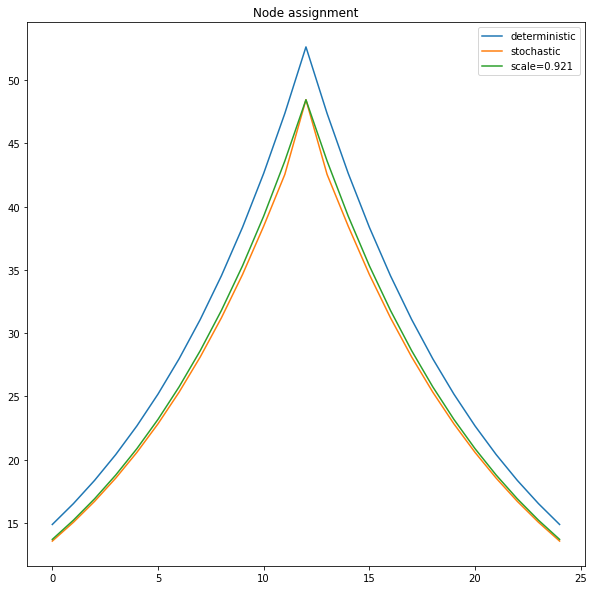

In [208]:
# How are we going to graph this?

sz = 1000

figsize = (10,10) 

#pos=nx.spring_layout(G,iterations=100)
plt.figure(figsize=figsize)
plt.title( "Node assignment" )

x = np.arange( N )
plt.plot( x, V_det, label='deterministic' )
plt.plot( x, V_sto, label='stochastic' )


# Also plot a scaled version of the deterministic value function to 
# see how well it matches the stochastic version.  At the moment
# I determine this by determining the ratio between maximum values
# of the determinstic and stochastic case, but I don't yet know 
# why it's this particular value.  
scale = V_sto.max() / V_det.max() 

plt.plot( x, scale * V_det, label='scale=%.3f'% scale )
plt.legend()

## Initial conclusions

So we can see that the stochastic value function decays exponentially at a faster rate than the deterministic value function.  I believe this makes sense as stochasticity represents a loss in acheivable value as we can't guarantee that we will reach the desired (most valuable) state by taking an action.  So a stochastic MDP represents a loss of information or increase in entropy I think?  Could I measure entropy of both functions and verify that claim?  Is that a useful concept?

A good quesiton would be to study how this ratio between deterministic and stochastic peaks changes as I vary the stochasticity in the transition function.  Is it always the same value?  Probably not.  Should vary with the amount of uncertainty, as more uncertainty would increase entropy in the value funciton I would think?

Another way to think about this is diffusion of the value function over the space I think.  Except an interesting problem is that the area under the stochastic value function is less than the value under the deterministic value function, meaning that overall value is lost when stochasticity is present.  Or said another way, it is more valuable to be in a determistic world than a stochastic world, which fits with our intuition.



## Reproducing Stochastic Value Function

In [209]:
V_det.max(), V_sto.max()

(52.63154006589952, 48.45445964685885)

In [210]:
r=10
g=gamma

r + g * ( 0 + g * ( r + g * ( 0 + g * r )))

24.661

In [211]:
r1 = r2 = r3 = r4 = r5 = r6 = r7 = r8 = r9 = r10 = 10
r2 = r4 = r6 = r8 = r10 = 0

# Compute the discounted future reward of taking a penalty of -10 at each step.
r1 + g * ( r2 + g * ( r3 + g * ( r4 + g * (r5 + g * ( r6 + g * (r7 + g * ( r8 + g * (r9 + g* (r10 )))))) )))


34.2800821

In [212]:
# As a recursive function:

def expected_future_reward( gamma, rs ):
  v = 0

  r = rs[0]

  v += r

  if len(rs) > 1:
    v += gamma * expected_future_reward( gamma, rs[1:] )
  
  return v

rs = [ 10, 0 ] * 400  # list of the 10 negative rewards

expected_future_reward( g, rs )

52.6315789473684

In [213]:
# As an iterative function:

def expected_future_reward_fast( gamma, rs ):
  v = 0

  
  v = rs[-1]

  for i in range( len(rs)-2, -1, -1 ):
    #print( i )
    r = rs[i]

    v = r + gamma * v

  return v

rs = [ 10, 0 ] * 10  # list of the 10 negative rewards

expected_future_reward_fast( g, rs )

46.23280765312794

In [214]:
for i in [10, 50, 100, 200, 400 ]:

  rs = [ 10, 0 ] * i 
  a = expected_future_reward( g, rs )
  b = expected_future_reward_fast( g, rs )

  print( a, b )


46.23280765312794 46.23280765312794
52.63018097900593 52.63018097900593
52.631578910236435 52.631578910236435
52.6315789473684 52.6315789473684
52.6315789473684 52.6315789473684


In [215]:

r = 10

# Compute the discounted future reward of taking a penalty of -10 at each step.
r + g * ( .8*r + g * (.8*r + g * ( .8*r + g * (.8*r + g * .8*r) )))

39.48472

In [216]:

def expected_future_reward_fast( gamma, rs ):
  v = 0
  
  v = rs[-1]

  for i in range( len(rs)-2, -1, -1 ):
    #print( i )
    r = rs[i]

    v = r + gamma * v

  return v

rs = [ 10, 0 ] * 10  # list of the 10 negative rewards

In [217]:
r1 = r2 = r3 = r4 = r5 = r6 = r7 = r8 = r9 = r10 = 10
r2 = r4 = r6 = r8 = r10 = 0

# Compute the discounted future reward of taking a penalty of -10 at each step.
10 + g * ( .1*10 )


10.9

## Examining Iterations of Value Iteration

If we examine each iteration of the value iteration process, can we reproduce the resulting value function?  And will this lead to insights on how to describe the final stochastic value function?

In [218]:
#%load_ext autoreload
#%autoreload 2

#import os
#os.environ["NUMBA_ENABLE_CUDASIM"] = ""
#del os.environ["NUMBA_ENABLE_CUDASIM"]

import numpy as np
import math

import numba
from numba import cuda

@cuda.jit
def bellman_update_st(xmax, V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma):
    
    num_actions = T_gpu.shape[1]  # assumes 1-d state space definition

    x = cuda.grid( 1 )

    #print( "pos %d -> x %d, y %d" % (pos, x, y ) ) 
    if x >= xmax:
      return


    # immediate reward
    r = R_gpu[ x ]

    # bellman update for stochastic mdp

    # first we have to compute the future expected value of taking
    # an action from this state.  We will keep track of the best
    # value we find in max_V.

    max_V = -np.inf

    # There is some additional parallelism we could take advantage of in here
    # if we'd like to kick off additional threads in parallel.  This will
    # get tricky because we'll need to either use atomic sum operations
    # or we'll need to build a pipeline of kernels to perform a reduction.
    # For now, performing the loop below on each thread, which will make
    # the algorithm slower than it could be on the GPU.
    for a in range(num_actions):

      # We have to sum up over all s' the expected future values
      V_sum = 0

      for xn in range(xmax):
        # probability of transitioning to the next state given
        # the current state and action
        P_n = T_gpu[ x, a, xn ]

        # value of next state
        V_n = V_i[ xn ]

        # expected future value of this transition
        V_sum += P_n * ( r + gamma * V_n )
      
      max_V = max( max_V, V_sum )

    # residual 
    res = abs(max_V - V_i[ x ])

    # update the value 
    V_o[ x ] = max_V

    # atomically update the residual
    cuda.atomic.max( residual_gpu, 0, res ) 
    


def numba_value_iteration_st_2(N, V, T, R, epsilon, gamma):
    # Move data to GPU so we can do two operations on it
    V_gpu_a = cuda.to_device(V)
    V_gpu_b = cuda.to_device(V)
    T_gpu = cuda.to_device(T)
    R_gpu = cuda.to_device(R)

    num_actions = T.shape[1]

    residual = np.array( [ -np.inf ], dtype=V.dtype )

    start = timer()    

    Vs = []

    count = 0
    while count == 0 or ( residual[0] > epsilon ):  # and count < 100 ):

      # Set up a ping-pong between the two value function buffers
      # so that V_i (input) is fixed during the iteration and
      # V_o (output) is updated at each iteration.
      if count % 2 == 0:
        V_i = V_gpu_a
        V_o = V_gpu_b
      else:
        V_i = V_gpu_b
        V_o = V_gpu_a

      # reset residual for next run
      residual[0] = -np.inf
    
      residual_gpu = cuda.to_device( residual )

      end1 = timer()

      num_threads = N
      threadsperblock = 256
      blockspergrid_x = math.ceil(N / threadsperblock)
      blockspergrid = blockspergrid_x     

      ### Perform Bellman upate
      bellman_update_st[blockspergrid,threadsperblock](N, V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma)

      end2 = timer()

      residual = residual_gpu.copy_to_host()

      end3 = timer()

      #print( "count %d: %f - %f secs (%f + %f + %f)" % (count, residual[0], end3 - start, end1 - start, end2-end1, end3-end2) )
      start = end3

      #np.save( 'val_iter/hist_%d.npy' % count, V_gpu.copy_to_host() )

      count += 1 

      Vs.append( V_o.copy_to_host() )


    return Vs



In [219]:
V = np.zeros( (N) )
T_sto = T = gen_stochastic_transition_function( N, 2 )
V_stos = numba_value_iteration_st_2( N, V, T, R, epsilon, gamma )

Building transition function


/home/bertrjr1/anaconda3/envs/gpu2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (92) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/bertrjr1/anaconda3/envs/gpu2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (92) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


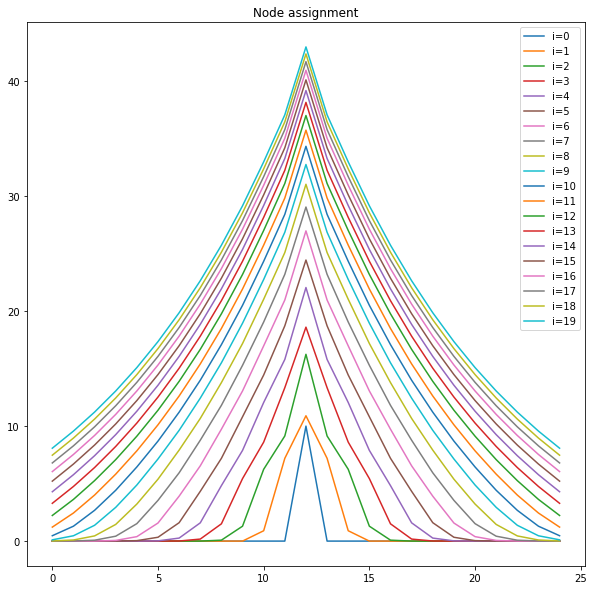

In [220]:
figsize = (10,10) 

#pos=nx.spring_layout(G,iterations=100)
plt.figure(figsize=figsize)
plt.title( "Node assignment" )

x = np.arange( N )
for i, V_sto in enumerate(V_stos[:20]):
  plt.plot( x, V_sto, label=f'i={i}' )

plt.legend()

### Manually reproducing each iteration

#### Iteration 0

In [221]:
V_stos[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [222]:
v0_c = 10.0


#### Iteration 1

In [223]:
V_stos[1]

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.9,
        7.2, 10.9,  7.2,  0.9,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ])

Here's where the values come from

In [224]:
0+g*(.1*0 +.8*0 + .1*10), 0+g*(.1*0 + .8*10 + .1*0), 10+g*(.1*0 +.8*0 + .1*10), 0+g*(.1*0 + .8*10 + .1*0),0+g*(.1*0 +.8*0 + .1*10)

(0.9, 7.2, 10.9, 7.2, 0.9)

Fully unrolled:

In [225]:
v1c = 10+g*(.1*0 +.8*0 + .1*(10+g*0))
v1c1 = 0+g*(.1*0 + .8*(10 +g*0) + .1*0)
v1c2 = 0+g*(.1*0 +.8*0 + .1*(10+g*0))

v1c, v1c1, v1c2

(10.9, 7.2, 0.9)

#### Iteration 2

In [226]:
V_stos[2]

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.081,  1.296,  6.246,  9.144, 16.246,  9.144,  6.246,  1.296,
        0.081,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ])

In [227]:
10+g*(.1*10.9 +.8*7.2 + .1*0.9), \
0+g*(.1*7.2 + .8*10.9 + 0.1*7.2), \
0+g*(.1*10.9 + .8*7.2 + 0.1*0.9), \
0+g*(.1*7.2 + .8*0.9), \
0+g*(.1*0.9)


(16.246000000000002,
 9.144000000000002,
 6.246,
 1.2960000000000003,
 0.08100000000000002)

Unrolled once:

In [228]:
v2c = 10+g*(.1*v1c +.8*v1c1 + .1*v1c2)
v2c1 = 0+g*(.1*v1c1 + .8*v1c + 0.1*v1c1)
v2c2 = 0+g*(.1*v1c + .8*v1c1 + 0.1*v1c2)
v2c3 = 0+g*(.1*v1c1 + .8*v1c2)
v2c4 = 0+g*(.1*v1c2)

v2c, v2c1, v2c2, v2c3, v2c4


(16.246000000000002,
 9.144000000000002,
 6.246,
 1.2960000000000003,
 0.08100000000000002)

Fully unrolled.  Pretty clear that this explodes.  Not seeing how I'm going to be able to reformulate this algebraicly into sums of peaks or some other linear combination of peaks.  Maybe that won't pan out.

In [229]:
v2c = 10+g*(.1*( 10+g*(.1*0 + .8*0         + .1*(10+g*0))  ) + \
            .8*(  0+g*(.1*0 + .8*(10 +g*0) + .1*0       )  ) + \
            .1*(  0+g*(.1*0 + .8*0         + .1*(10+g*0))  )   \
            )
v2c1 = 0+g*(.1*(  0+g*(.1*0 + .8*(10 +g*0) + .1*0       )  ) + \
            .8*( 10+g*(.1*0 + .8*0         + .1*(10+g*0))  ) + \
            .1*(  0+g*(.1*0 + .8*(10 +g*0) + .1*0       )  )   \
            )
v2c2 = 0+g*(.1*(10+g*(.1*0 + .8*0         + .1*(10+g*0) )  ) + \
            .8*( 0+g*(.1*0 + .8*(10 +g*0) + .1*0        )  ) + \
            .1*( 0+g*(.1*0 + .8*0         + .1*(10+g*0) )  )   \
            )
v2c3 = 0+g*(.1*(0+g*(.1*0 + .8*(10 +g*0) + .1*0         )  ) + \
            .8*(0+g*(.1*0 + .8*0         + .1*(10+g*0)  )  )   \
            )
v2c4 = 0+g*(.1*(0+g*(.1*0 + .8*0         + .1*(10+g*0)  )  )   )

v2c, v2c1, v2c2, v2c3, v2c4


(16.246000000000002,
 9.144000000000002,
 6.246,
 1.2960000000000003,
 0.08100000000000002)

### Initial Conclusions

This seems to be an intractible way to proceed.  What I was hoping to see was an algebraic method to describe the peaks as a linear combination of peaks discounted by the uncertainty parameters would fall out.  Such as $.6 * V_{peak} + .1 * V_{peak} + .1 * V_{peak}$, where $V_{peak}$ is the max value of the determistic peak.  I thought this would be apparent by factoring out the geometric series like we do for deterministic peaks.  Doesn't look like it's going to be that easy though.


# Probabilty of reachabilty


What I'm thinking at the moment is that I could probably explain the stochastic value function by running a monte carlo rollout like process where I generate a probability $P( s_o | s_i )$ of arriving at each state $s_o \in S$ starting from state $s_i \in S$.  It might be that applying $P( s_o | s_i ) \cdot V_{det}( s_o )$ would yeild the stochastic value function $V_{sto}$?  But seems like something's missing there, as the stochastic value function wouldn't depend on $s_o$.  So maybe something like $V_{sto}(s_i) = \sum_{s \in S} P( s | s_i ) \cdot V_{det}( s )$.  That might make sense and could be easy to test in a small environment.

Testing this hyptothesis:

$V_{sto}(s_i) = \sum_{s \in S} P( s | s_i ) \cdot V_{det}( s )$.  


## Random Walk

Test a random walk approach to generating $P( s| s_i )$.

In [230]:
V_sto = V_stos[-1]

How can we determine $P( s | s_i )$?

We need to start from $s_i$ and run many Monte Carlo runs where we randomly select an action then apply the transition function, counting each state we reach.  We probably need to run many iterations and maybe need to apply some exploration policies such as epsilon-greedy or an Ornstein–Uhlenbeck process in order to get good exploration?  We don't want a random walk as we won't explore the extremes very well.  (And epsilon-greedy here probably isn't appropriate either.)

Let's try out a simple random walk first:


In [231]:
# Choose an initial state
s_i = 0

# Perform a random walk and count the states we end up at.
counts = np.zeros_like( V_sto )

for runs in range(10000):
  s = s_i
  for i in range( 100 ):
    # Choose an action randomly.  One trick here is we need to know how many
    # actions are available from this state.  We can figure this out by determining
    # the out-degree of this node in the graph.

    out_degree = G.degree( s )

    #print( f"Out degree of {s} is {out_degree}" )

    # Select a uniform random action
    a = np.random.randint( 0, out_degree )  # generate from 0 to out_degree - 1

    #print( f'selected random action {a}')

    # Extract the probability of transitioning to sp from this state for this
    # action
    prob = T[ s, a, : ]

    #print( f'next state probability {prob}')

    # Use this probablity distribution to randomly determine which next state
    # sp we arrive at

    sp = np.random.choice( range(len(prob)), p = prob )

    #print( f'next state {sp}')


    s = sp

    counts[ sp ] += 1

print( f'counts: {counts}')

probs = counts/counts.sum()
print( f'probabiliteis: {probs}')


KeyboardInterrupt: 

In [ ]:
V_det, V_sto

In [ ]:
V_det * probs 

In [ ]:
np.sum( V_det.max() * probs )

In [ ]:
np.sum( V_det * probs ), V_sto[0]

## Using Deterministic MDP Policy

Trying using the determistic policy to generate $P( s | s_i )$.

### Manually for a single state

First generate the policy for the deterministic MDP.


In [ ]:

policy_det = np.zeros_like( V_det, dtype=int )
policy_det_nice = []

for s in range(N):

  # Choose an action randomly.  One trick here is we need to know how many
  # actions are available from this state.  We can figure this out by determining
  # the out-degree of this node in the graph.

  out_degree = G.degree( s )

  print( f"Out degree of {s} is {out_degree}" )

  values = np.zeros( (out_degree) )
  action_nice = []

  for a in range(out_degree):

    print( f'  action {a}')

    # Extract the probability of transitioning to sp from this state for this
    # action
    prob = T[ s, a, : ]

    # Use this probablity distribution to randomly determine which next state
    # sp we arrive at

    sp = np.argmax( prob )

    print( f'    next state {sp}' ) #', probability {prob}')

    value = V_det[sp]

    print( f'    value at {sp} is {value}')

    values[a] = value

  # Best action
  a_star = np.argmax( values )

  print( f'  a_star {a_star}')

  policy_det[s] = a_star

print( f'policy {policy_det}' )

In [ ]:
# Choose an initial state
s_i = 0

# Perform a random walk and count the states we end up at.
counts = np.zeros_like( V_sto )

for runs in range(100):
  s = s_i
  for i in range( 10 ):
    # Select the action from the determistic policy.
    a = policy_det[s]

    #print( f'selected random action {a}')

    # Extract the probability of transitioning to sp from this state for this
    # action
    prob = T[ s, a, : ]

    #print( f'next state probability {prob}')

    # Use this probablity distribution to randomly determine which next state
    # sp we arrive at

    sp = np.random.choice( range(len(prob)), p = prob )

    #print( f'next state {sp}')


    s = sp

    counts[ sp ] += 1

print( f'counts: {counts}')

probs = counts/counts.sum()
print( f'probabiliteis: {probs}')


In [ ]:
V_det, V_sto

In [ ]:
V_det * probs 

In [ ]:
discounts = np.zeros_like( V_det )
s_i = 0
for s in range(N):
   discounts[ s ] = gamma ** (s - s_i + 1)

discounts



In [ ]:
V_det, V_det * discounts, V_det * discounts * probs, np.sum( V_det * discounts * probs ), V_sto[0]

### Applying over every state

This seems pretty close.  Let's see how it looks over every state.

In [ ]:
# Perform a random walk and count the states we end up at.
counts = np.zeros( (N, N)  )
probs  = np.zeros( (N, N)  )

# Choose an initial state
for s_i in range(N):

  #print( f'****** s_i {s_i}')

  for runs in range(100):
    s = s_i
    for i in range( 25 ):
      # Select the action from the determistic policy.
      a = policy_det[s]

      #print( f'action {a}')

      # Extract the probability of transitioning to sp from this state for this
      # action
      prob = T[ s, a, : ]

      #print( f'next state probability {prob}')

      # Use this probablity distribution to randomly determine which next state
      # sp we arrive at

      sp = np.random.choice( range(len(prob)), p = prob )

      #print( f'next state {sp}')


      s = sp

      #print( f'counts shape {counts.shape}')

      counts[ s_i, sp ] += 1

  #print( f'counts: {counts[s_i,:]}')

  probs[s_i,:] = counts[s_i,:]/counts[s_i,:].sum()

#print( f'probabiliteis: {probs}')

discounts = np.zeros( (N,N) )

# This doesn't appear to be quite right
for s_i in range(N):
  for s in range(N):
    discounts[ s_i, s ] = gamma ** ( abs(s - s_i + 1)  )  # HACK: Changing this around shifts the error in the plots below


V_pred = np.zeros_like( V_sto )

for s_i in range(N):
  sum = np.sum( V_det * discounts[s_i] * probs[s_i] )
  V_pred[ s_i ] = sum
  
  #print( f's_i {s_i}  calc\'d {sum}  actual {V_sto[s_i]}' )



In [ ]:
# How are we going to graph this?

sz = 1000

figsize = (10,10) 

#pos=nx.spring_layout(G,iterations=100)
plt.figure(figsize=figsize)
plt.title( "Node assignment" )

x = np.arange( N )
plt.plot( x, V_det, label='deterministic' )
plt.plot( x, V_sto, label='stochastic' )
plt.plot( x, V_pred, label='predicted' )


plt.legend()

We can see that it's pretty accurate on one side of the reward, but it's a bit off on the right hand side.  There's a place a couple of cells above where I call out an extra +1 I can insert into the code for generating the discount factors that will shift around whether this error is on the left hand side or right hand side of the peak.  It's not clear to my why this is happening.

Playing with it made me realize that if I apply that +1 in some places but not others, I can get very close to the real value function, which I implement in the next section.  I would like to find a way to remove this.

## Hack I can't explain but is nearly exact

If I insert a hack value into the discount factor distance calculation, I can get a pretty close approximation of the stochastic MDP.  If we ignore the hack for a moment, the way to understand what I'm doing here is:

What this corresponds to is $V_{sto}(s_i) = \sum_{s \in S} \Gamma(s_i, s ) \cdot P( s | s_i, \pi_{det}) \cdot V_{det}( s )$, where $\Gamma( s_i, s ) = \gamma^{ \delta( s_i, s ) }$, where $\delta( s_i, s)$ is the distance between states $s_i$ and $s$ through the determistic MDP, and $P( s | s_i, \pi_{det} )$ is the probability of reaching state $s$ starting from state $s_i$ following the policy resulting from solving the determistic version of the MDP, resulting in value function $V_{det}$ and policy $\pi_{det}$. 

So this basically says that the value at the current state is the sum of the probabilities of reaching state $s$ following the determistic policy $\pi_{det}$ multiplied by the discounted future value of reaching that state.

In [ ]:
# Perform a random walk and count the states we end up at.
counts = np.zeros( (N, N)  )
probs  = np.zeros( (N, N)  )

s_peak = np.argmax( V_det )

# Choose an initial state
for s_i in range(N):

  print( f'****** s_i {s_i}')

  counts[ s_i, s_peak ] += 1000

  for run in range(1000):
    #print( f's_i {s_i} run {run}')
    s = s_i
    peak_count = 0

    for i in range( N*4 ):
      # Select the action from the determistic policy.
      a = policy_det[s]

      #print( f'action {a}')

      # Extract the probability of transitioning to sp from this state for this
      # action
      prob = T[ s, a, : ]

      #print( f'next state probability {prob}')

      # Use this probablity distribution to randomly determine which next state
      # sp we arrive at

      sp = np.random.choice( range(len(prob)), p = prob )

      #print( f'next state {sp}')


      s = sp

      #print( f'counts shape {counts.shape}')

      counts[ s_i, sp ] += 1

      if s == s_peak:
        peak_count += 1

      if peak_count >= 1:
        break

  #print( f'counts: {counts[s_i,:]}')

  probs[s_i,:] = counts[s_i,:]/counts[s_i,:].sum()

#print( f'probabiliteis: {probs}')

discounts = np.zeros( (N,N) )

# This doesn't appear to be quite right
for s_i in range(N):
  for s in range(N):

    ###################### HERE IS THE HACK
    hack_offset = 0
    if s_i < s_peak:
      hack_offset = 1 # why is this needed?
    elif s_i == s_peak:
      hack_offset = 0  # disabled in this case
    elif s_i > s_peak:
      hack_offset = 1  # why is this needed?
    discounts[ s_i, s ] = gamma ** ( abs(s - s_i ) + hack_offset  )
    ###################### HERE IS THE HACK


V_pred = np.zeros_like( V_sto )

s_peak = np.argmax( V_det )

for s_i in range(N):
  sum = np.sum( V_det * discounts[s_i] * probs[s_i] )
  V_pred[ s_i ] = sum

  
  #print( f's_i {s_i}  calc\'d {sum}  actual {V_sto[s_i]}' )

# How are we going to graph this?

sz = 1000

figsize = (10,10) 

#pos=nx.spring_layout(G,iterations=100)
plt.figure(figsize=figsize)
plt.title( "Node assignment" )

x = np.arange( N )
plt.plot( x, V_det, label='deterministic' )
plt.plot( x, V_sto, label='stochastic' )
plt.plot( x, V_pred, label='predicted' )


plt.legend()

## Initial Conclusions

This appears to be very close to stochastic MDP, and it also makes sense intuitively why this method would work.  There will be some challenges to make it tractable though.  It would be very expensive to compute the Probability of Reachability for every state in a large MDP.  Is there a way to compute this exactly with some closed form method?  Or given a certain type of transition function (e.g., Gaussian uncertainty) can this be computed more easily to make it tractable using Gaussian uncertainty propagation like Kalman filters?

It's very exciting to find a method that works at all for any case.  I wasn't sure I'd be able to get this far during my PhD time frame.



## Reexamining the hack

One concern that remains -- why did I need to insert the hack above?  Makes me wonder if I'm coming to a bad conclusion due to confirmation bias.  "I was able to match the curve with this hack, therefore I must have figured it out."  Need to go back and understand why this is happening.

# Third Try


## Smaller world

In [ ]:
# Generate a 1D grid world using networkx to do it.
G = nx.generators.random_graphs.random_lobster( 5, .0, .1, seed=5)

#pos=nx.spring_layout(G,iterations=100)

nodes = np.array( list(G.nodes) )

N = len(nodes)
o = np.ones( N )

xscale = 50
pos={}
for i in range(N):
  pos[i] = np.array([ i * xscale, 0 ])


sz = 700

figsize = (10,10) 

plt.figure(figsize=figsize)
plt.title( "Node assignment" )

edge_colors= np.c_[ [ .8 * o, .8 * o, .9 * o, .7 * o ] ].T
nx.draw_networkx(G, pos,  node_size=sz, node_color=(.8, .8, .9, 1.0), edge_color=edge_colors, with_labels=True)


In [ ]:
# Instead generate a dictionary with key of the node and value of a list of 
# outgoing nodes
edges = {}
for edge in list(G.edges):
  #print( edge, type(edge) )
  src, dst = edge

  # Generate from src to dst
  try:
    edges[src] += [ dst ]
  except KeyError:
    edges[src] = [ dst ]

  # And since this is a undirected graph generate the reverse transition
  try:
    edges[dst] += [ src ]
  except KeyError:
    edges[dst] = [ src ]

# Determine the maximum number of outgoing transitions from any node
max_out_degree = -1
for src, outgoing in edges.items():
  max_out_degree = max( max_out_degree, len(outgoing) )

print( 'edges: ', edges )
print( 'max_out_degree: ', max_out_degree )



In [ ]:
# Let's create a reward function defined over the graph

R = np.zeros( (N) )

# Put a reward at a random node in the graph.  I picked node
# a node arbitrarily and put a reward at that location.
R[int(N/2)] = 10

# define bellman residual threshold
epsilon = .00001

# discount factor
gamma = 0.9


print( "Solving MDP" )
V = np.zeros( (N) )
T_det = T = gen_deterministic_transition_function( N, 2 )
V_det = numba_value_iteration_st( N, V, T, R, epsilon, gamma )

V = np.zeros( (N) )
T_sto = T = gen_stochastic_transition_function( N, 2 )
V_sto = numba_value_iteration_st( N, V, T, R, epsilon, gamma )

In [ ]:
# How are we going to graph this?

sz = 1000

figsize = (10,10) 

#pos=nx.spring_layout(G,iterations=100)
plt.figure(figsize=figsize)
plt.title( "Node assignment" )

x = np.arange( N )
plt.plot( x, V_det, label='deterministic' )
plt.plot( x, V_sto, label='stochastic' )


# Also plot a scaled version of the deterministic value function to 
# see how well it matches the stochastic version.  At the moment
# I determine this by determining the ratio between maximum values
# of the determinstic and stochastic case, but I don't yet know 
# why it's this particular value.  
scale = V_sto.max() / V_det.max() 

plt.plot( x, scale * V_det, label='scale=%.3f'% scale )
plt.legend()

In [ ]:

policy_det = np.zeros_like( V_det, dtype=int )
policy_det_nice = []

for s in range(N):

  # Choose an action randomly.  One trick here is we need to know how many
  # actions are available from this state.  We can figure this out by determining
  # the out-degree of this node in the graph.

  out_degree = G.degree( s )

  print( f"Out degree of {s} is {out_degree}" )

  values = np.zeros( (out_degree) )
  action_nice = []

  for a in range(out_degree):

    print( f'  action {a}')

    # Extract the probability of transitioning to sp from this state for this
    # action
    prob = T[ s, a, : ]

    # Use this probablity distribution to randomly determine which next state
    # sp we arrive at

    sp = np.argmax( prob )

    print( f'    next state {sp}' ) #', probability {prob}')

    value = V_det[sp]

    print( f'    value at {sp} is {value}')

    values[a] = value

  # Best action
  a_star = np.argmax( values )

  print( f'  a_star {a_star}')

  policy_det[s] = a_star

print( f'policy {policy_det}' )

In [ ]:
print(N)
# Perform a random walk and count the states we end up at.
counts = np.zeros( (N, N)  )
probs  = np.zeros( (N, N)  )

s_peak = np.argmax( V_det )

print( f'peak at {s_peak}' )

# Choose an initial state
for s_i in range(N):

  #print( f'****** s_i {s_i}')

  for run in range(1000):
    #print( f's_i {s_i} run {run}')
    s = s_i
    peak_count = 0

    for i in range( N*4 ):
      # Select the action from the determistic policy.
      a = policy_det[s]

      #print( f'action {a}')

      # Extract the probability of transitioning to sp from this state for this
      # action
      prob = T[ s, a, : ]

      #print( f'next state probability {prob}')

      # Use this probablity distribution to randomly determine which next state
      # sp we arrive at

      sp = np.random.choice( range(len(prob)), p = prob )

      #print( f'next state {sp}')


      s = sp

      #print( f'counts shape {counts.shape}')

      counts[ s_i, sp ] += 1

      if sp == s_peak:
        peak_count += 1

      if peak_count >= 1:
        break

  print( f'counts: \n{counts[s_i,:]}')

  probs[s_i,:] = counts[s_i,:]/counts[s_i,:].sum()

print( f'probabilities: \n{probs}')

discounts = np.zeros( (N,N) )

# This doesn't appear to be quite right
for s_i in range(N):
  for s in range(N):

    ###################### HERE IS THE HACK
    hack_offset = 0
    if s_i < s_peak:
      hack_offset = 1 # why is this needed?
    elif s_i == s_peak:
      hack_offset = 0  # disabled in this case
    elif s_i > s_peak:
      hack_offset = 1  # disabled in this case
    discounts[ s_i, s ] = gamma ** ( abs(s - s_i ) + hack_offset  )
    ###################### HERE IS THE HACK

print( 'discounts: \n', discounts )

V_pred = np.zeros_like( V_sto )

s_peak = np.argmax( V_det )

for s_i in range(N):
  sum = np.sum( V_det * discounts[s_i] * probs[s_i] )
  V_pred[ s_i ] = sum

  
  #print( f's_i {s_i}  calc\'d {sum}  actual {V_sto[s_i]}' )

# How are we going to graph this?

sz = 1000

figsize = (10,10) 

#pos=nx.spring_layout(G,iterations=100)
plt.figure(figsize=figsize)
plt.title( "Node assignment" )

x = np.arange( N )
plt.plot( x, V_det, label='deterministic' )
plt.plot( x, V_sto, label='stochastic' )
plt.plot( x, V_pred, label='predicted' )


plt.legend()

### I see the problem

Ahh, I see what's going on now.  The deterministic policy once we reach the peak causes us to go left.

In [ ]:
policy_det

When I follow the deterministic policy and record counts of states that I visit, it counts the state with the peak, but it also counts this extra state that's part of the minimum cycle. 

In [ ]:
figsize = (10,10) 

#pos=nx.spring_layout(G,iterations=100)
plt.figure(figsize=figsize)

x = np.arange( N )
plt.plot( x, counts[0], label='counts' )

plt.legend()

figsize = (10,10) 

#pos=nx.spring_layout(G,iterations=100)
plt.figure(figsize=figsize)

x = np.arange( N )
plt.plot( x, probs[0], label='probabilities' )


plt.legend()

 So that's throwing off the estimation of the probability of reachability.  The reason the hack worked is it basically just ignores the fact that the minimum cycle exists.  So maybe instead I should try to do a run until we reach the state with the peak and see what happens?


## Terminate at peak

We're going to do our simulation runs but stop once we reach the peak state.

In [ ]:
print(N)
# Perform a random walk and count the states we end up at.
counts = np.zeros( (N, N)  )
probs  = np.zeros( (N, N)  )

s_peak = np.argmax( V_det )

print( f'Peak is at {s_peak}')

# Choose an initial state
for s_i in range(N):

  print( f'****** s_i {s_i}')
  peak_count = 0

  ##### HACK HERE TOO #####
  # if I artificially plant a large number of counts here to simulate 
  # going to this state infinitely often, I can alter the value function.
  counts[s_i, s_peak] += 1000
  #####

  for run in range(100):
    print( f's_i {s_i} run {run}')
    s = s_i
    for i in range( N*2 ):
      # Select the action from the determistic policy.
      a = policy_det[s]

      print( f'action {a}')

      # Extract the probability of transitioning to sp from this state for this
      # action
      prob = T[ s, a, : ]

      print( f'next state probability {prob}')

      # Use this probablity distribution to randomly determine which next state
      # sp we arrive at

      sp = np.random.choice( range(len(prob)), p = prob )

      print( f'next state {sp}')


      s = sp

      #print( f'counts shape {counts.shape}')

      counts[ s_i, sp ] += 1

      if s == s_peak:
        peak_count += 1

      if peak_count >= 1:
        break

  print( f'counts: {counts[s_i,:]}')

  probs[s_i,:] = counts[s_i,:]/counts[s_i,:].sum()

#print( f'probabiliteis: {probs}')

discounts = np.zeros( (N,N) )

# This doesn't appear to be quite right
for s_i in range(N):
  for s in range(N):

    ###################### HERE IS THE HACK
    hack_offset = 0
    if s_i < s_peak:
      hack_offset = 1 # why is this needed?
    elif s_i == s_peak:
      hack_offset = 1  # disabled in this case
    elif s_i > s_peak:
      hack_offset = 1  # disabled in this case
    discounts[ s_i, s ] = gamma ** ( abs(s - s_i ) + hack_offset  )
    ###################### HERE IS THE HACK


V_pred = np.zeros_like( V_sto )

s_peak = np.argmax( V_det )

for s_i in range(N):
  sum = np.sum( V_det * discounts[s_i] * probs[s_i] )
  V_pred[ s_i ] = sum

  
  #print( f's_i {s_i}  calc\'d {sum}  actual {V_sto[s_i]}' )

# How are we going to graph this?

sz = 1000

figsize = (10,10) 

#pos=nx.spring_layout(G,iterations=100)
plt.figure(figsize=figsize)

x = np.arange( N )
plt.plot( x, counts[0], label='counts' )

plt.legend()

figsize = (10,10) 

#pos=nx.spring_layout(G,iterations=100)
plt.figure(figsize=figsize)

x = np.arange( N )
plt.plot( x, probs[0], label='probabilities' )


plt.legend()

figsize = (10,10) 

#pos=nx.spring_layout(G,iterations=100)
plt.figure(figsize=figsize)
plt.title( "Node assignment" )

x = np.arange( N )
plt.plot( x, V_det, label='deterministic' )
plt.plot( x, V_sto, label='stochastic' )
plt.plot( x, V_pred, label='predicted' )


plt.legend()

# Gaussian

Try to use a real gaussian to generate the probabilities.



## Recompute Solution



In [ ]:
# Generate a 1D grid world using networkx to do it.
G = nx.generators.random_graphs.random_lobster( 10, .0, .1, seed=5)

#pos=nx.spring_layout(G,iterations=100)

nodes = np.array( list(G.nodes) )

N = len(nodes)
o = np.ones( N )

xscale = 50
pos={}
for i in range(N):
  pos[i] = np.array([ i * xscale, 0 ])


sz = 700

figsize = (10,10) 

plt.figure(figsize=figsize)
plt.title( "Node assignment" )

edge_colors= np.c_[ [ .8 * o, .8 * o, .9 * o, .7 * o ] ].T
nx.draw_networkx(G, pos,  node_size=sz, node_color=(.8, .8, .9, 1.0), edge_color=edge_colors, with_labels=True)


Let's recompute our solution for this 1D grid world.

In [ ]:
# Instead generate a dictionary with key of the node and value of a list of 
# outgoing nodes
edges = {}
for edge in list(G.edges):
  #print( edge, type(edge) )
  src, dst = edge

  # Generate from src to dst
  try:
    edges[src] += [ dst ]
  except KeyError:
    edges[src] = [ dst ]

  # And since this is a undirected graph generate the reverse transition
  try:
    edges[dst] += [ src ]
  except KeyError:
    edges[dst] = [ src ]

# Determine the maximum number of outgoing transitions from any node
max_out_degree = -1
for src, outgoing in edges.items():
  max_out_degree = max( max_out_degree, len(outgoing) )

print( 'edges: ', edges )
print( 'max_out_degree: ', max_out_degree )



In [ ]:
# Let's create a reward function defined over the graph

R = np.zeros( (N) )

# Put a reward at a random node in the graph.  I picked node
# a node arbitrarily and put a reward at that location.
R[int(N/2)] = 10

# define bellman residual threshold
epsilon = .00001

# discount factor
gamma = 0.9


print( "Solving MDP" )
V = np.zeros( (N) )
T_det = T = gen_deterministic_transition_function( N, 2 )
V_det = numba_value_iteration_st( N, V, T, R, epsilon, gamma )

V = np.zeros( (N) )
T_sto = T = gen_stochastic_transition_function( N, 2 )
V_sto = numba_value_iteration_st( N, V, T, R, epsilon, gamma )

In [ ]:
# How are we going to graph this?

sz = 1000

figsize = (10,10) 

#pos=nx.spring_layout(G,iterations=100)
plt.figure(figsize=figsize)
plt.title( "Node assignment" )

x = np.arange( N )
plt.plot( x, V_det, label='deterministic' )
plt.plot( x, V_sto, label='stochastic' )


# Also plot a scaled version of the deterministic value function to 
# see how well it matches the stochastic version.  At the moment
# I determine this by determining the ratio between maximum values
# of the determinstic and stochastic case, but I don't yet know 
# why it's this particular value.  
scale = V_sto.max() / V_det.max() 

plt.plot( x, scale * V_det, label='scale=%.3f'% scale )
plt.legend()

In [ ]:

policy_det = np.zeros_like( V_det, dtype=int )
policy_det_nice = []

for s in range(N):

  # Choose an action randomly.  One trick here is we need to know how many
  # actions are available from this state.  We can figure this out by determining
  # the out-degree of this node in the graph.

  out_degree = G.degree( s )

  print( f"Out degree of {s} is {out_degree}" )

  values = np.zeros( (out_degree) )
  action_nice = []

  for a in range(out_degree):

    print( f'  action {a}')

    # Extract the probability of transitioning to sp from this state for this
    # action
    prob = T[ s, a, : ]

    # Use this probablity distribution to randomly determine which next state
    # sp we arrive at

    sp = np.argmax( prob )

    print( f'    next state {sp}' ) #', probability {prob}')

    value = V_det[sp]

    print( f'    value at {sp} is {value}')

    values[a] = value

  # Best action
  a_star = np.argmax( values )

  print( f'  a_star {a_star}')

  policy_det[s] = a_star

print( f'policy {policy_det}' )

In [ ]:
print(N)
# Perform a random walk and count the states we end up at.
counts = np.zeros( (N, N)  )
probs  = np.zeros( (N, N)  )

s_peak = np.argmax( V_det )

print( f'peak at {s_peak}' )

# Choose an initial state
for s_i in range(N):

  #print( f'****** s_i {s_i}')

  for run in range(1000):
    #print( f's_i {s_i} run {run}')
    s = s_i
    peak_count = 0

    for i in range( N*4 ):
      # Select the action from the determistic policy.
      a = policy_det[s]

      #print( f'action {a}')

      # Extract the probability of transitioning to sp from this state for this
      # action
      prob = T[ s, a, : ]

      #print( f'next state probability {prob}')

      # Use this probablity distribution to randomly determine which next state
      # sp we arrive at

      sp = np.random.choice( range(len(prob)), p = prob )

      #print( f'next state {sp}')


      s = sp

      #print( f'counts shape {counts.shape}')

      counts[ s_i, sp ] += 1

      if sp == s_peak:
        peak_count += 1

      if peak_count >= 1:
        break

  print( f'counts: \n{counts[s_i,:]}')

  probs[s_i,:] = counts[s_i,:]/counts[s_i,:].sum()

print( f'probabilities: \n{probs}')

discounts = np.zeros( (N,N) )

# This doesn't appear to be quite right
for s_i in range(N):
  for s in range(N):

    ###################### HERE IS THE HACK
    hack_offset = 0
    if s_i < s_peak:
      hack_offset = 1 # why is this needed?
    elif s_i == s_peak:
      hack_offset = 0  # disabled in this case
    elif s_i > s_peak:
      hack_offset = 1  # disabled in this case
    discounts[ s_i, s ] = gamma ** ( abs(s - s_i ) + hack_offset  )
    ###################### HERE IS THE HACK

print( 'discounts: \n', discounts )

V_pred = np.zeros_like( V_sto )

s_peak = np.argmax( V_det )

for s_i in range(N):
  sum = np.sum( V_det * discounts[s_i] * probs[s_i] )
  V_pred[ s_i ] = sum

  
  #print( f's_i {s_i}  calc\'d {sum}  actual {V_sto[s_i]}' )

# How are we going to graph this?

sz = 1000

figsize = (10,10) 

#pos=nx.spring_layout(G,iterations=100)
plt.figure(figsize=figsize)
plt.title( "Node assignment" )

x = np.arange( N )
plt.plot( x, V_det, label='deterministic' )
plt.plot( x, V_sto, label='stochastic' )
plt.plot( x, V_pred, label='predicted' )


plt.legend()

## Gaussian parameters

Our transition function uncertainty is a pretty close fit to a normal distribution with a sigma of 0.5 (or variance 0.25).

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


# Generate some data for this demonstration.
data = np.zeros( (N) )
s_peak = int(N/2)
data[s_peak] = .8
data[s_peak-1] = .1
data[s_peak+1] = .1

print( data ) 
# Fit a normal distribution to the data:
mu, std = s_peak, .5 

# Plot the histogram.

#plt.hist(data, bins=25, density=True, alpha=0.6, color='g')


plt.plot( data, color=[0,.7,0,.7], marker='o', linewidth=3 )

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, color=[0,0,0,.7], linewidth=2)

title = "Fit results: std = %.2f" % (std)
plt.title(title)


plt.show()

We can now take transitions thorugh the value function by propagating uncertainty using the same machinery we would use for Kalman filters.  

Let's assume that we start at state 2 and that we follow the deterministic policy for 4 steps (until we reach the peak at state 6).  Our prior is that we have a probability of 1 being at state 2 and a probability everywhere else.

In [ ]:
state = np.zeros( (N) )
state[2] = 1.0

!pip install attrdict
from attrdict import AttrDict as ad

def gaussian( mean, var ):
  return ad( { 'mean': mean, 'var': var } )

state = gaussian( 2.0, .001 )


If we follow the deterministic policy, we will move to the right towards state 3.  Our transition function for going right can then be described as a gaussian with mean 1 and variance 0.25 (std dev of 0.5).

In [ ]:

transition = gaussian( 1.0, .25 )

In [ ]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)
    
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

Lets perform that process step prediction

In [ ]:
prior = predict( state, transition )

In [ ]:
def plot_gaussian( gaussian, **kwargs ):
  # Plot the PDF.
  xmin, xmax = 0, N
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, gaussian.mean, math.sqrt(gaussian.var) )
  plt.plot(x, p, **kwargs)

In [ ]:
plot_gaussian( state, label='state' )
plot_gaussian( transition, label='transition function' )
plot_gaussian( prior, label='prediction' )
plt.legend()


Lets take a few successive steps and show the resulting distribution

In [ ]:
predictions = []

plot_gaussian( state, label='state' )

for i in range(4):
  if len(predictions) == 0:
    # Predict from the starting state
    pred = predict( state, transition )
    predictions.append( pred )
  else:
    # Use the last prediction as our starting state for this prediction
    pred = predict( predictions[-1], transition )
    predictions.append( pred )

  plot_gaussian( pred, label=f't={i+1}' )
plt.legend()



## Gaussian transition from deterministic policy

Lets hook this up to the determinstic policy and let it run until it reaches the peak from each state and examine the resulting distributions.

In [ ]:
# Perform a random walk and count the states we end up at.

s_peak = np.argmax( V_det )

print( f'peak at {s_peak}' )

def dbg(*args):
  #print(*args)
  return

plt.figure()
#plt.title( f's_i:  {s_i}')

reachabilities = []


# Choose an initial state
for s_i in range(N):

  dbg( f'****** s_i {s_i}')

  for run in range(1):
    #print( f's_i {s_i} run {run}')
    s = s_i
    peak_count = 0

    # Set up our initial state as a gaussian with very little uncertainty
    state = gaussian( s_i, 0.001 )

    predictions = []

    for i in range( N ):
      dbg( f'state {s}')

      # Select the action from the determistic policy.
      a = policy_det[s]

      dbg( f'action {a}')

      # Extract the probability of transitioning to sp from this state for this
      # action
      prob = T[ s, a, : ]
      
      dbg( f'next state probability {prob}')

      # Rephrase that transition as a gaussian transition going either left 
      # or right.  Recall that we need to phrase this as a movement relative
      # to the current state.
      t_mean = np.argmax( prob )
      transition = gaussian( t_mean - s, 0.25 )

      dbg( f'gaussian version {transition}')

      if len(predictions) == 0:
        pred = predict( state, transition )
      else:
        pred = predict( predictions[-1], transition )

      predictions.append( pred )

      # From the prediciton, we need to determine which state we are in based
      # off which state the mean most closely falls within.
      sp = int( pred.mean + .5 )  # round to nearest int

      dbg( f'sp {sp}')

      if sp == s_peak:
        peak_count += 1

      # Break out of loop if we reach the peak of the deterministic value function
      if peak_count >= 1:
        break

      # Get the next iteration of the loop ready
      s = sp



  #plot_gaussian( state, label=f'state {s_i}' )

  for i in range(len(predictions)-1):
      #plot_gaussian( predictions[i], label=f't={i+1}' )
      pass

  plot_gaussian( predictions[-1], label=f's_i of {s_i}' )

  reachabilities.append( predictions[ -1 ] )

  plt.legend()

## Using gaussians as reachability probability

Need to figure out how I'll use this gaussian curve to generate probabilities that I can apply to each state.  I think I need to integrate the curve over each state to obtain a probabiity at each state $s$ from the density function range $(s-0.5, s+0.5)$.  So basically I need a histogram of the probabiity density function.

### Area under gaussians

To integrate from -inf to z under a standard normal distribution with 0 mean and variance 1, the formula is:

$Phi(z) = 0.5 + 0.5 * erf(z / \sqrt(2))$

Where $erf( \cdot )$ is the error function.

In [ ]:
# Calculate the probability from -inf to 0 of the standard normal distribution. 
# It will come out to a probability of 0.5.
Phi = 0.5 + 0.5 * math.erf(0 / math.sqrt(2))
Phi

In [ ]:
def phi( z ):
  return 0.5 + 0.5 * math.erf(z / math.sqrt(2))

In [ ]:
# Now compute the probability of standard deviations
for devs in [1, 2, 3]:
  print( f'probability under {devs} standard deviations: {phi( 1.0 * devs ) - phi( -( 1.0 * devs ) )}' )

In [ ]:
# Now to perform the same calculation on a general gaussian with arbitrary 
# mean and standard deviation

g1 = gaussian( 2.0, 3.0 )

for devs in [1, 2, 3]:
  beg = g1.mean - devs * math.sqrt(g1.var)
  end = g1.mean + devs * math.sqrt(g1.var)

  txbeg = (beg - g1.mean) / math.sqrt( g1.var )
  txend = (end - g1.mean) / math.sqrt( g1.var )

  print( f'probability under {devs} standard deviations [{beg}, {end}] -> [{txbeg, txend}]: {phi( txend ) - phi( txbeg )}' )

In [ ]:
def int_gaussian( g, x1, x2 ):
  tx_x1 = (x1 - g.mean) / math.sqrt( g.var )
  tx_x2 = (x2 - g.mean) / math.sqrt( g.var )

  return phi( tx_x2 ) - phi( tx_x1 )


In [ ]:
# Now to perform the same calculation on a general gaussian with arbitrary 
# mean and standard deviation

g1 = gaussian( 2.0, 3.0 )

for devs in [1, 2, 3]:
  beg = g1.mean - devs * math.sqrt(g1.var)
  end = g1.mean + devs * math.sqrt(g1.var)

  print( f'probability under {devs} standard deviations [{beg}, {end}] -> [{txbeg, txend}]: {int_gaussian( g1, beg, end )}' )

### Computing probability bins

Now that we have the machinery to compute integrals of gaussians, lets compute probabilities by computing bins for each discrete state in our 1D grid world.

In [ ]:
# We saved off the probabilty of reachabilty into the reachabilities[] variable up above.

disc_reach = []



for s_i in range(N):
    # Get the continuous representation of reachability from state s_i as
    # a gaussian
    g_cont = reachabilities[s_i]

    # We want to generate a discretized version of this
    disc = np.zeros( (N) )
  
    # Compute area under the gaussian for each state's bin
    for s in range(N):
      disc[s] = int_gaussian( g_cont, s - 0.5, s + 0.5 )

    disc_reach.append( disc )




In [ ]:
plot_gaussian( reachabilities[6], label=f's_i of {s_i}' )
plt.legend()

plt.bar( range(N), disc_reach[6] )

$V_{sto}(s_i) = \sum_{s \in S} \Gamma(s_i, s ) \cdot P( s | s_i, \pi_{det}) \cdot V_{det}( s )$, where $\Gamma( s_i, s ) = \gamma^{ \delta( s_i, s ) }$, where $\delta( s_i, s)$ is the distance between states $s_i$ and $s$ through the determistic MDP, and $P( s | s_i, \pi_{det} )$ is the probability of reaching state $s$ starting from state $s_i$ following the policy resulting from solving the determistic version of the MDP, resulting in value function $V_{det}$ and policy $\pi_{det}$. 



In [ ]:

discounts = np.zeros( (N,N) )

# This doesn't appear to be quite right
for s_i in range(N):
  for s in range(N):

    ###################### HERE IS THE HACK
    hack_offset = 0
    if s_i < s_peak:
      hack_offset = 0 # why is this needed?
    elif s_i == s_peak:
      hack_offset = 0  # disabled in this case
    elif s_i > s_peak:
      hack_offset = 0  # why is this needed?
    discounts[ s_i, s ] = gamma ** ( abs(s - s_i ) + hack_offset  )
    ###################### HERE IS THE HACK


V_pred = np.zeros_like( V_sto )

s_peak = np.argmax( V_det )

#for s_i in range(N):
  #sum = np.sum( V_det * discounts[s_i] * disc_reach[s_i] )
  #sum = np.sum( V_det * disc_reach[s_i] )
  #V_pred[ s_i ] = sum

  
  #print( f's_i {s_i}  calc\'d {sum}  actual {V_sto[s_i]}' )

for s_i in range(N):
  sum = np.sum( V_det * discounts[s_i] * disc_reach[s_i] )
  V_pred[ s_i ] = sum


# How are we going to graph this?

sz = 1000

figsize = (10,10) 

#pos=nx.spring_layout(G,iterations=100)
plt.figure(figsize=figsize)
plt.title( "Prediction using gaussian uncertainty propagation" )

x = np.arange( N )
plt.plot( x, V_det, label='deterministic' )
plt.plot( x, V_sto, label='stochastic' )
plt.plot( x, V_pred, label='predicted (via gaussians)' )


plt.legend()

Maybe instead I just need to compute the probability of reaching the peak, then exponential decay from there.

In [ ]:
s_peak = int(N/2)




discounts = np.zeros( (N,N) )

# This doesn't appear to be quite right
for s_i in range(N):
  for s in range(N):

    ###################### HERE IS THE HACK
    hack_offset = 0
    if s_i < s_peak:
      hack_offset = 0 # why is this needed?
    elif s_i == s_peak:
      hack_offset = 0  # disabled in this case
    elif s_i > s_peak:
      hack_offset = 0  # why is this needed?
    discounts[ s_i, s ] = gamma ** ( abs(s - s_i ) + hack_offset  )
    ###################### HERE IS THE HACK


V_pred = np.zeros_like( V_sto )

s_peak = np.argmax( V_det )

#for s_i in range(N):
  #sum = np.sum( V_det * discounts[s_i] * disc_reach[s_i] )
  #sum = np.sum( V_det * disc_reach[s_i] )
  #V_pred[ s_i ] = sum

  
  #print( f's_i {s_i}  calc\'d {sum}  actual {V_sto[s_i]}' )


if False:  # This didn't work
  for s_i in range(N):
    # What's the probability of reaching the state where the peak is at?
    reach = disc_reach[ s_i ][ s_peak ]  

    if s_i == 6:  reach = .8
    print( f'prob of reaching {s_peak} from {s_i} is {reach}')

    V_pred[ s_i ] = V_det[s_peak] * discounts[s_i, s_peak] * reach
    V_pred[ s_i ] = np.sum( V_det * discounts[s_i] * disc_reach[s_i] )

if True: # This kind of works magically
  # Compute the most value we can possibly acheive in this stochastic MDP
  # based off the "lost value" that occurs due to the stochastic transition.
  
  V_sto_max = np.sum( V_det * discounts[s_peak] * disc_reach[s_peak] )

  # Treat that as if it were a new determistic value, and then exponentially
  # decay it as if it were a deterministic MDP.
  for s_i in range(N):
    V_pred[ s_i ] = V_sto_max * discounts[s_i, s_peak] 

# How are we going to graph this?

sz = 1000

figsize = (10,10) 

#pos=nx.spring_layout(G,iterations=100)
plt.figure(figsize=figsize)
plt.title( "Prediction using gaussian uncertainty propagation" )

x = np.arange( N )
plt.plot( x, V_det, label='deterministic' )
plt.plot( x, V_sto, label='stochastic' )
plt.plot( x, V_pred, label='predicted (via gaussian max)' )


plt.legend()

In [ ]:
reachabilities

## Tentative Conclusions

If this method is the right approach, what it implies is that uncertainty is used to determine how much peak value is lost, but doesn't affect the shape of the propagation outward from the reward.

We might use this fact then to compute a "lossy" reward and then use normal FastMDP to compute the value function.

Need to expand this out to understand if this scales to more complex rewards.

# 2D Grid World with Gaussian Transition Function


## Preliminaries

In [ ]:


import numpy as np
import operator


import matplotlib.pyplot as plt


import IPython.display as dp
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec 

import time

import numba as nb

from timeit import default_timer as timer

import networkx as nx

!pip install attrdict
from attrdict import AttrDict as ad


# Plotting view
el=40
az=30


In [ ]:
#%load_ext autoreload
#%autoreload 2

#import os
#os.environ["NUMBA_ENABLE_CUDASIM"] = ""
#del os.environ["NUMBA_ENABLE_CUDASIM"]

import numpy as np
import math

import numba
from numba import cuda

@cuda.jit
def bellman_update_st(xmax, V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma):
    
    num_actions = T_gpu.shape[1]  # assumes 1-d state space definition

    x = cuda.grid( 1 )

    #print( "pos %d -> x %d, y %d" % (pos, x, y ) ) 
    if x >= xmax:
      return


    # immediate reward
    r = R_gpu[ x ]

    # bellman update for stochastic mdp

    # first we have to compute the future expected value of taking
    # an action from this state.  We will keep track of the best
    # value we find in max_V.

    max_V = -np.inf

    # There is some additional parallelism we could take advantage of in here
    # if we'd like to kick off additional threads in parallel.  This will
    # get tricky because we'll need to either use atomic sum operations
    # or we'll need to build a pipeline of kernels to perform a reduction.
    # For now, performing the loop below on each thread, which will make
    # the algorithm slower than it could be on the GPU.
    for a in range(num_actions):

      # We have to sum up over all s' the expected future values
      V_sum = 0

      for xn in range(xmax):
        # probability of transitioning to the next state given
        # the current state and action
        P_n = T_gpu[ x, a, xn ]

        # value of next state
        V_n = V_i[ xn ]

        # expected future value of this transition
        V_sum += P_n * ( r + gamma * V_n )
      
      max_V = max( max_V, V_sum )

    # residual 
    res = abs(max_V - V_i[ x ])

    # update the value 
    V_o[ x ] = max_V

    # atomically update the residual
    cuda.atomic.max( residual_gpu, 0, res ) 
    


def numba_value_iteration_st(N, V, T, R, epsilon, gamma):
    # Move data to GPU so we can do two operations on it
    V_gpu_a = cuda.to_device(V)
    V_gpu_b = cuda.to_device(V)
    T_gpu = cuda.to_device(T)
    R_gpu = cuda.to_device(R)

    num_actions = T.shape[1]

    residual = np.array( [ -np.inf ], dtype=V.dtype )

    start = timer()    

    count = 0
    while count == 0 or ( residual[0] > epsilon ):  # and count < 100 ):

      # Set up a ping-pong between the two value function buffers
      # so that V_i (input) is fixed during the iteration and
      # V_o (output) is updated at each iteration.
      if count % 2 == 0:
        V_i = V_gpu_a
        V_o = V_gpu_b
      else:
        V_i = V_gpu_b
        V_o = V_gpu_a

      # reset residual for next run
      residual[0] = -np.inf
    
      residual_gpu = cuda.to_device( residual )

      end1 = timer()

      num_threads = N
      threadsperblock = 256
      blockspergrid_x = math.ceil(N / threadsperblock)
      blockspergrid = blockspergrid_x     

      ### Perform Bellman upate
      bellman_update_st[blockspergrid,threadsperblock](N, V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma)

      end2 = timer()

      residual = residual_gpu.copy_to_host()

      end3 = timer()

      #print( "count %d: %f - %f secs (%f + %f + %f)" % (count, residual[0], end3 - start, end1 - start, end2-end1, end3-end2) )
      start = end3

      #np.save( 'val_iter/hist_%d.npy' % count, V_gpu.copy_to_host() )

      count += 1 


    return V_o.copy_to_host()



## 2D grid world

Let's adapt what we've done above into a 2D grid world

In [ ]:
dim = 10
sz = 1000

# Generate a 1D grid world using networkx to do it.
G = nx.generators.lattice.grid_2d_graph( dim, dim )

#pos=nx.spring_layout(G,iterations=200)

scale = 500
pos={}
for i in range(dim):
  for j in range(dim):
    pos[(i,j)] = (i*scale, j*scale)

nodes = np.array( list(G.nodes) )

N = len(nodes)
o = np.ones( N )
edge_colors= np.c_[ [ .8 * o, .8 * o, .9 * o, .7 * o ] ].T

figsize = (10,10) 

plt.figure(figsize=figsize)

nx.draw_networkx(G, pos,  node_size=sz, node_color=(.8, .8, .9, 1.0), edge_color=edge_colors, with_labels=True)


In [ ]:
# Instead generate a dictionary with key of the node and value of a list of 
# outgoing nodes
edges = {}
for edge in list(G.edges):
  #print( edge, type(edge) )
  src, dst = edge

  # Generate from src to dst
  try:
    edges[src] += [ dst ]
  except KeyError:
    edges[src] = [ dst ]

  # And since this is a undirected graph generate the reverse transition
  try:
    edges[dst] += [ src ]
  except KeyError:
    edges[dst] = [ src ]

# Determine the maximum number of outgoing transitions from any node
max_out_degree = -1
for src, outgoing in edges.items():
  max_out_degree = max( max_out_degree, len(outgoing) )

print( 'edges: ', edges )
print( 'max_out_degree: ', max_out_degree )

def neighbors( s ):
  node = state_to_node( s ) 

  return edges[ node ]

def node_to_state( node ):
  return node[0] * dim + node[1]

def state_to_node( s ):
  x = s // dim
  y = s  % dim
  node = (x, y)
  return node

## 2D Transition Functions

In [ ]:

# Generate a transition function for our 2D world

def gen_deterministic_transition_function(N, max_out_degree):

  T = np.zeros( (N, max_out_degree, N)  )

  print( "Building transition function" )
  
  for s in range(N):

    nbrs = neighbors( s )

    # Each neighbor is reached by an action
    for a, nbr in enumerate(nbrs):

      # In a deterministic MDP there is no uncertainty in the transition.
      # When we take action a, we always arrive at nbr.
      sp = node_to_state( nbr )

      T[ s, a, sp ] = 1.0

  return T
  
def gen_stochastic_transition_function(N, max_out_degree, bleed=0.1):

  T = np.zeros( (N, max_out_degree, N)  )

  print( "Building transition function" )
  
  for s in range(N):

    nbrs = neighbors( s )

    # Each neighbor is reached by an action
    for a, nbr in enumerate(nbrs):

      # In a stochastic MDP there is some uncertainty in the transition.
      # When we take action a, we won't always arrive at nbr, but may instead
      # arrive at another state.  

      # We want to approximate a gaussian uncertainty distribution.  When we 
      # attempt an action a which would normally arrive at nbr, we will instead
      # have a small probability of transitioning to one of the neighbors of
      # 
      sp = node_to_state( nbr )

      nbr_nbrs = neighbors( sp )

      assert bleed * len( nbr_nbrs ) < 1.0, "bleed is too high"

      prob_left = 1.0
      for nbr_nbr in nbr_nbrs:
        sn = node_to_state( nbr_nbr )
        T[ s, a, sn ] = bleed
        prob_left -= bleed
      
      assert prob_left > 0.0
      T[ s, a, sp ] = prob_left

  return T
  

## Solve with Value Iteration

In [ ]:
%pdb off
# Let's create a reward function defined over the graph

R = np.zeros( (N) )

# Put a reward at a random node in the graph.  I picked node
# a node arbitrarily and put a reward at that location.
R[ node_to_state( (4, 4) ) ] = 10

# define bellman residual threshold
epsilon = .00001

# discount factor
gamma = 0.9


print( "Solving MDP" )
V = np.zeros( (N) )
T_det = T = gen_deterministic_transition_function( N, max_out_degree )
V_det = numba_value_iteration_st( N, V, T, R, epsilon, gamma )

V = np.zeros( (N) )
T_sto = T = gen_stochastic_transition_function( N, max_out_degree )
V_sto = numba_value_iteration_st( N, V, T, R, epsilon, gamma )

In [ ]:
def plot_it( V_o, dim , title = None ):

  V_o = V_o.reshape( (dim,dim) )

  fig = plt.figure(figsize=(12,6), constrained_layout=False)
  gs = fig.add_gridspec(1,2)

  #plt.imshow( R, cmap="Reds" )
  #plt.colorbar()

  #plt.figure()
  #plt.imshow( V )
  #plt.colorbar()

  ax = fig.add_subplot(gs[0, 0])
  if title:
    fig.suptitle( title, fontsize=16 )

  plt.title( 'Value function, V')
  p = plt.imshow( V_o, cmap="coolwarm" )
  plt.colorbar(p)


  from mpl_toolkits.mplot3d import Axes3D

  X = np.arange(0, V_o.shape[0], 1.0)
  Y = np.arange(0, V_o.shape[1], 1.0)
  X, Y = np.meshgrid(X, Y)

  Z = V_o

  print( X.shape, V_o.shape )


  ax = fig.add_subplot(gs[0, 1], projection='3d')
  plt.title( 'Value function, V')
  #plt.imshow( V_o, cmap="jet" )



  ax.view_init(elev=el, azim=az)
  ax.plot_surface(X, Y, Z, cmap='coolwarm',
                        linewidth=0, antialiased=False)
  plt.colorbar(p)


      



In [ ]:
%pdb off

plot_it( V_det, dim, title='Deterministic' )
plot_it( V_sto, dim, title='Stochastic' )

## Optimal Deterministic Policy

In [ ]:

policy_det = np.zeros_like( V_det, dtype=int )
policy_det_nice = []

for s in range(N):

  # Choose an action randomly.  One trick here is we need to know how many
  # actions are available from this state.  We can figure this out by determining
  # the out-degree of this node in the graph.

  node = state_to_node( s )

  out_degree = G.degree( node )

  #print( f"Out degree of {s} is {out_degree}" )

  values = np.zeros( (out_degree) )
  action_nice = []

  for a in range(out_degree):

    #print( f'  action {a}')

    # Extract the probability of transitioning to sp from this state for this
    # action
    prob = T[ s, a, : ]

    # Use this probablity distribution to randomly determine which next state
    # sp we arrive at

    sp = np.argmax( prob )

    #print( f'    next state {sp}' ) #', probability {prob}')

    value = V_det[sp]

    #print( f'    value at {sp} is {value}')

    values[a] = value

  # Best action
  a_star = np.argmax( values )

  #print( f'  a_star {a_star}')

  policy_det[s] = a_star

print( f'policy {policy_det}' )

In [ ]:

def plot_policy( V, pi, dim ):

  V = V.reshape( (dim,dim) )

  fig = plt.figure(figsize=(18,18), constrained_layout=False)
  gs = fig.add_gridspec(2,2)

  #plt.imshow( R, cmap="Reds" )
  #plt.colorbar()

  #plt.figure()
  #plt.imshow( V )
  #plt.colorbar()

  ax = fig.add_subplot(gs[0, 0])
  plt.title( 'Policy, pi')
  p = plt.imshow( V, cmap="coolwarm" )
  plt.colorbar(p)

  N = len(pi)
  for s in range(N):

    node = state_to_node( s )

    a = pi[ s ]

    nbrs = neighbors( s )

    sp_node = nbrs[ a ] 

    #print( f'{node}->{sp_node}')
    x, y = node
    x2, y2 = sp_node

    sx = x + .3 * (x2 - x)
    ex = x + .8 * (x2 - x)
    sy = y + .3 * (y2 - y)
    ey = y + .8 * (y2 - y)

    plt.annotate('', xy=(ex, ey), xycoords='data',
             xytext=(sx, sy), textcoords='data',
             arrowprops=dict(arrowstyle="->"), color='g')
    plt.annotate(f'{x},{y}', xy=(x2, y2), xycoords='data',
             xytext=(x-.2, y+.07), textcoords='data',
             color='g')

plot_policy( V_det, policy_det, dim )




## 2D Gaussian Transition Uncertainty

### Gaussian Fitting

In [ ]:
# Plot the uncertainty of our transition function so we can fit a multivariate 
# gaussian to it.

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,6), constrained_layout=False)
gs = fig.add_gridspec(1,2)

prob = np.zeros( (dim,dim) )
prob[ 4, 4 ] = .6
prob[ 4, 3 ] = .1
prob[ 4, 5 ] = .1
prob[ 3, 4 ] = .1
prob[ 5, 4 ] = .1

V_o = prob
X = np.arange(0, V_o.shape[0], 1.0)
Y = np.arange(0, V_o.shape[1], 1.0)
X, Y = np.meshgrid(X, Y)

Z = V_o

print( X.shape, V_o.shape )

ax = fig.add_subplot(gs[0, 0], projection='3d')
plt.title( 'Transition uncertainty')
#plt.imshow( V_o, cmap="jet" )


ax.view_init(elev=el, azim=az)
p = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                      linewidth=0, antialiased=False)
plt.colorbar(p)


ax = fig.add_subplot(gs[0, 1], projection='3d')
X = np.arange(0, V_o.shape[0], 1.0)
Y = np.arange(0, V_o.shape[1], 1.0)
X, Y = np.meshgrid(X, Y)

from scipy.stats import multivariate_normal
gaussian = multivariate_normal([4, 4], [[.25, 0], [0, 0.25]])

pos = np.dstack((X, Y))
ax.view_init(elev=el, azim=az)
p = ax.plot_surface( X, Y, gaussian.pdf( pos ), cmap='coolwarm',
                      linewidth=0, antialiased=False )
plt.colorbar(p)

### Gaussian Prediction

Kalman filter's predict step

In [ ]:
state = np.zeros( (N) )
state[2] = 1.0



def gaussian( mean, covar ):
  return ad( { 'mean': np.array( mean ), 'covar': np.array( covar ) } )

state = gaussian( [2.0,2.0], [ [.001,0], [0,.001] ] )

In [ ]:
def predict(pos, movement):
    new_mean = []
    new_covar = []
    for dim in range(len(pos.mean)):
      new_mean.append( pos.mean[dim] + movement.mean[dim] )
      new_covar.append( pos.covar[dim] + movement.covar[dim] )
    
    pred = gaussian(new_mean, new_covar )
    #print( f'prediction is {pred}')
    return pred

In [ ]:
def plot_mv_gaussian( g, **kwargs):

  X = np.arange(0, V_o.shape[0], .1)
  Y = np.arange(0, V_o.shape[1], .1)
  X, Y = np.meshgrid(X, Y)

  from scipy.stats import multivariate_normal
  gaussian = multivariate_normal(g.mean, g.covar )

  pos = np.dstack((X, Y))
  ax.view_init(elev=el, azim=az)
  p = ax.plot_surface( X, Y, gaussian.pdf( pos ), cmap='coolwarm',
                        linewidth=0, antialiased=False, **kwargs )
  

In [ ]:
%pdb off 

fig = plt.figure( figsize=(6,6*5) )
gs = fig.add_gridspec(5,1)
ax = fig.add_subplot(gs[0, 0], projection='3d')

state = gaussian( [2.0,2.0], [ [.001,0], [0,.001] ] )

transition = gaussian( [1.0,1.0], [ [.25,0], [0,.25] ] )

plot_mv_gaussian( state, label='state' )

predictions = []
for i in range(4):
  ax = fig.add_subplot(gs[i+1, 0], projection='3d')
  ax.set_zlim( 0, 1 )
  if len(predictions) == 0:
    # Predict from the starting state
    pred = predict( state, transition )
    predictions.append( pred )
  else:
    # Use the last prediction as our starting state for this prediction
    pred = predict( predictions[-1], transition )
    predictions.append( pred )

  plot_mv_gaussian( pred, label=f't={i+1}' )

#plt.colorbar()
#plt.legend()


### Follow Deterministic Policy

In [ ]:
%pdb off

# Follow deterministic policy and count the states we end up at.

s_peak = np.argmax( V_det )

print( f'peak at {s_peak}' )

def dbg(*args):
  #print(*args)
  return

plt.figure()
#plt.title( f's_i:  {s_i}')

reachabilities = []


# Choose an initial state
for s_i in range(N):

  dbg( f'****** s_i {s_i}')

  s_i_node = state_to_node( s_i )

  for run in range(1):  # how many runs to average over?
    #print( f's_i {s_i} run {run}')
    s = s_i
    peak_count = 0

    node = state_to_node( s )

    # Set up our initial state as a gaussian with very little uncertainty
    state = gaussian( node, [ [0.001,0],[0,.001] ] )

    predictions = []

    for i in range( N ):  # how many steps to take in world?
      dbg( f'state {s}')
      s_node = state_to_node( s )

      # Select the action from the determistic policy.
      a = policy_det[s]

      dbg( f'action {a}')

      # Extract the probability of transitioning to sp from this state for this
      # action
      prob = T[ s, a, : ]
      
      dbg( f'next state probability {prob}')

      # Rephrase that transition as a gaussian transition going either left 
      # or right.  Recall that we need to phrase this as a movement relative
      # to the current state.
      t_sp = np.argmax( prob )
      t_node = state_to_node( t_sp )

      t_move = np.array( t_node ) - np.array( s_node )

      transition = gaussian( t_move, [ [0.25,0],[0,.25] ] )

      dbg( f'gaussian version {transition}')

      if len(predictions) == 0:
        pred = predict( state, transition )
      else:
        pred = predict( predictions[-1], transition )

      predictions.append( pred )

      # From the prediciton, we need to determine which state we are in based
      # off which state the mean most closely falls within.
      sp_node = [ int( pred.mean[0] + .5 ), int( pred.mean[1] + .5 ) ]  # round to nearest int
      sp = node_to_state( sp_node )


      dbg( f'sp {sp}')

      if sp == s_peak:
        peak_count += 1

      # Break out of loop if we reach the peak of the deterministic value function
      if peak_count >= 2:
        # For debug, lets attach the number of steps it took us to reach the
        # peak
        predictions[-1]['num_steps'] = i
        break

      # Get the next iteration of the loop ready
      s = sp



  #plot_gaussian( state, label=f'state {s_i}' )
  if s_i_node[0] == 0:
    # Plot one row

    for i in range(len(predictions)-1):
        #plot_gaussian( predictions[i], label=f't={i+1}' )
        pass

    fig = plt.figure( figsize=(6,6) )
    gs = fig.add_gridspec(1,1)
    ax = fig.add_subplot(gs[0, 0], projection='3d')

    plot_mv_gaussian( predictions[-1], label=f's_i of {s_i}' )

  reachabilities.append( predictions[ -1 ] )

  #plt.legend()

In [ ]:
reachabilities


### Area Under Multivariate Gaussian

In [ ]:
# Here's what we were doing for a univariate gaussian earlier.  Need to adapt
# this to multivariate.

if False:
  g1 = gaussian( 2.0, 3.0 )

  for devs in [1, 2, 3]:
    beg = g1.mean - devs * math.sqrt(g1.var)
    end = g1.mean + devs * math.sqrt(g1.var)

    txbeg = (beg - g1.mean) / math.sqrt( g1.var )
    txend = (end - g1.mean) / math.sqrt( g1.var )

    print( f'probability under {devs} standard deviations [{beg}, {end}] -> [{txbeg, txend}]: {phi( txend ) - phi( txbeg )}' )

For a gaussian with mean $\mu = 0$ and standard deviation $\sigma > 0$, the probability that a value $|x|$ lies within a range $\alpha$ of the mean is:

$$ Prob( |x| < \alpha ) = erf( \frac{ \alpha }{ \sqrt(2) \cdot \sigma } ) $$.

If we instead wish to know the probability from $-\infty$ to $x$ it is calculated as:

$$ \Phi( x, \alpha ) \equiv Prob( x < \alpha ) = 0.5 + 0.5 * erf(  \frac{ \alpha }{ \sqrt(2) \cdot \sigma } ) $$ because at $x = 0$, the probability is 0.5 and from that we need to add to that the probability that $x$ lies $\alpha$ away from the mean $\mu$, which is half the probabilty that $|x|$ lies $\alpha$ away from the mean $\mu$.

From https://apps.dtic.mil/dtic/tr/fulltext/u2/401722.pdf, I found that for a multi-variate gaussian with means $\mu$ of 0 and standard deviation $\sigma$ the same in all dimensions, the integral is (see Eq 6):

$$ Prob( |x_1| < \alpha_1, |x_2| < \alpha_2, \cdots, |x_n| < \alpha_n ) = erf( \frac{ \alpha_1 }{ \sigma \cdot \sqrt(2) } ) \cdot erf( \frac{ \alpha_2 }{ \sigma \cdot \sqrt(2) } ) \cdots erf( \frac{ \alpha_n }{ \sigma \cdot \sqrt(2) } )  $$

This luckily is the case I am concerned with, as I wish to integrate from grid points $(x_1, y_1), (x_2, y_2)$ where $x_2 > x_1$ and $y_2 > y_1$, where I want to integrate over the rectangle defined by $(x_1, y_1), (x_2, y_2)$.

To construct the 2D equivalent of the $\Phi( x, \alpha)$ function, as the dimensions are independent, the 2D $\Phi( x_1, x_2, \alpha_1, \alpha_2 )$ is just the product of the 1D $\Phi( \cdot)$ functions along each dimension:

$$ 
\Phi_2( x_1, x_2, \alpha_1, \alpha_2 ) = \Phi( x_1, \alpha_1 ) \cdot \Phi( x_2, \alpha_2 )$$.

In [ ]:
# Error function 

# 1 dimensional integration from -inf to z under 1d normal distribution
def phi( z ):
  return 0.5 + 0.5 * math.erf(z / math.sqrt(2))




### Multivariate Gaussian Probability Bins

Let's make a function that takes an arbitrary gaussian, converts it to the standard normal form, and determined the probabilities of lying between $(x_1, x_2)$ along the first dimension and $(y_1, y_2)$ along the second dimension.

In [ ]:


def int_mv_gaussian( g, x1, x2, y1, y2 ):

  assert x2 >= x1
  assert y2 >= y1

  # assumes covariance off-axis values are 0.  won't work if there
  # is corrleation betwen x and y.
  #print( f'gaussian: {g}' )
  #print( f'x range: {x1} ... {x2}')
  #print( f'y range: {y1} ... {y2}')

  tx_x1 = (x1 - g.mean[0]) / math.sqrt( g.covar[0,0] )
  tx_x2 = (x2 - g.mean[0]) / math.sqrt( g.covar[0,0] )

  #print( f'normalized x range: {tx_x1} ... {tx_x2}')

  tx_y1 = (y1 - g.mean[1]) / math.sqrt( g.covar[1,1] )
  tx_y2 = (y2 - g.mean[1]) / math.sqrt( g.covar[1,1] )

  #print( f'normalized y range: {tx_y1} ... {tx_y2}')

  p1 = phi( tx_x2 ) - phi( tx_x1 )
  p2 = phi( tx_y2 ) - phi( tx_y1 )

  #print( f'p1( {tx_x1}, {tx_x2} ): {p1}')
  #print( f'p2( {tx_y1}, {tx_y2} ): {p2}')

  prob = p2 * p1

  #print( f'prob: {prob}')

  return prob


In [ ]:
g = gaussian( [0,0], [[1.0,0], [0,1.0]] )
int_mv_gaussian( g, 0, 1, -np.inf, np.inf ) # should be around .34

In [ ]:
# Generate some test cases to find any obvious problems.

%pdb off 

# Test on a standard normal distribution
g = gaussian( [0,0], [[1.0,0], [0,1.0]] )

assert int_mv_gaussian( g, -np.inf, np.inf, -np.inf, np.inf ) == 1.0
assert int_mv_gaussian( g, -np.inf, 0, -np.inf, 0 ) == 0.25
assert int_mv_gaussian( g, -np.inf, np.inf, -np.inf, 0 ) == 0.5
assert int_mv_gaussian( g, 0, np.inf, -np.inf, 0 ) == 0.25

# Test on a standard normal distribution with shifted mean
g = gaussian( [1,1], [[1.0,0], [0,1.0]] )

assert int_mv_gaussian( g, -np.inf, np.inf, -np.inf, np.inf ) == 1.0
assert int_mv_gaussian( g, -np.inf, 1, -np.inf, 1 ) == 0.25
assert int_mv_gaussian( g, -np.inf, np.inf, -np.inf, 1 ) == 0.5

# Test on a standard normal distribution with shifted variance
g = gaussian( [0,0], [[2.0,0], [0,2.0]] )

assert int_mv_gaussian( g, -np.inf, np.inf, -np.inf, np.inf ) == 1.0
assert int_mv_gaussian( g, -np.inf, 0, -np.inf, 0 ) == 0.25
assert int_mv_gaussian( g, -np.inf, np.inf, -np.inf, 0 ) == 0.5

# Test on a standard normal distribution with shifted mean and variance
g = gaussian( [3,3], [[2.0,0], [0,2.0]] )

assert int_mv_gaussian( g, -np.inf, np.inf, -np.inf, np.inf ) == 1.0
assert int_mv_gaussian( g, -np.inf, 3, -np.inf, 3 ) == 0.25
assert int_mv_gaussian( g, -np.inf, np.inf, -np.inf, 3 ) == 0.5



In [ ]:
g = gaussian( [5,5], [[1.0,0], [0,1.0]] )

# Plot the function over a range of inputs.  Should resemble a sigmoid function 
# which starts at 0 and grows to 1 as x goes from 0 to 10 here.  As our mean is
# at 5, we should be at 0.5 for alpha2 == 5.

for alpha2 in range( 0, 10 ):
  x = []
  v = []
  for alpha1 in range( 10 ):
    x.append( alpha1 )
    v.append(  int_mv_gaussian( g, -np.inf, alpha1, -np.inf, alpha2 ) )

  plt.xlabel( 'alpha1')
  plt.ylabel( '$Prob( x_1  < \alpha_1, x_2 < \alpha_2 )$')
  plt.plot( x, v, label=f'alpha2: {alpha2}')
plt.legend()

In [ ]:
# Show probability bins around each value.  Should resemble a normal 
# distribution, but won't be smooth.

g = gaussian( [5,5], [[1.0,0], [0,1.0]] )

for alpha2 in [ 5 ]:
  x = []
  v = []
  for alpha1 in range( 10 ):
    x.append( alpha1 )
    v.append(  int_mv_gaussian( g, alpha1 - .5, alpha1 + 0.5, -np.inf, alpha2 ) )

  plt.xlabel( 'alpha1')
  plt.ylabel( '$Prob( x_1  < \alpha_1, x_2 < \alpha_2 )$')
  plt.plot( x, v, label=f'alpha2: {alpha2}')
plt.legend()

In [ ]:
# Create a function that will discretize a gaussian, returning the probability
# bins for each integer value.

def discretize_gaussian( g_cont ):
  # We want to generate a discretized version of this
  disc = np.zeros( (N) )

  s_i_node = state_to_node( 0 )

  # Compute area under the gaussian for each state's bin
  for s in range(N):

    s_node = state_to_node( s )

    disc[s] = int_mv_gaussian( g_cont, s_node[0] - 0.5, s_node[0] + 0.5, s_node[1] - 0.5, s_node[1] + 0.5 )

  return disc

In [ ]:
# Double check with plots that the discretized bins resemble the gaussian they 
# are generated from.

%pdb off


def plot_mv_surf( prob_bins, dim, **kwargs):

  X = np.arange(0, dim, 1)
  Y = np.arange(0, dim, 1)
  X, Y = np.meshgrid(X, Y)

  ax.view_init(elev=el, azim=az)
  p = ax.plot_surface( X, Y, prob_bins, cmap='coolwarm',
                        linewidth=0, antialiased=False, **kwargs )

def plot_mv_bar( prob_bins, dim, **kwargs):

  X = np.arange(0, dim, 1)
  Y = np.arange(0, dim, 1)
  X, Y = np.meshgrid(X, Y)

  print( f'X: {X.shape}, Y: {Y.shape}, dim: {dim}, prob_bins: {prob_bins.shape}')

  top = prob_bins
  bottom = np.zeros_like(top)
  width = depth = 1

  ax.view_init(elev=el, azim=az)
  p = ax.bar3d( X.ravel(), Y.ravel(), bottom.ravel(), width, depth, top.ravel(), shade=True, cmap='coolwarm' )


g = gaussian( [5,5], [[1.0,0], [0,1.0]] )

g_disc = discretize_gaussian( g )

print( f'g_disc: {g_disc.shape}')
fig = plt.figure( figsize=(6,6) )
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0, 0], projection='3d')

plot_mv_gaussian( g, label=f's_i of {s_i}' )
#plt.legend()

fig = plt.figure( figsize=(6,6) )
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0, 0], projection='3d')
plot_mv_bar( g_disc.reshape( (dim,dim) ) , dim, color='r' )

fig = plt.figure( figsize=(6,6) )
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0, 0], projection='3d')
plot_mv_surf( g_disc.reshape( (dim,dim) ) , dim, color='r' )

### Computing Reachability

In [ ]:
# We saved off the probabilty of reachabilty into the reachabilities[] variable 
# up above as a continuous gaussian.  Lets convert those continuous gaussian
# representations into discretized bins.  What we need is the abilty to 
# understand what the probability is of reaching state s starting from state s_i
# while following the deterministic policy.

disc_reach = []



for s_i in range(N):
    # Get the continuous representation of reachability from state s_i as
    # a gaussian
    g_cont = reachabilities[s_i]

    # We want to generate a discretized version of this
    disc = np.zeros( (N) )

    s_i_node = state_to_node( s_i )
  
    # Compute area under the gaussian for each state's bin
    for s in range(N):

      s_node = state_to_node( s )

      disc[s] = int_mv_gaussian( g_cont, s_node[0] - 0.5, s_node[0] + 0.5, s_node[1] - 0.5, s_node[1] + 0.5 )

    disc_reach.append( disc )




In [ ]:
reachabilities, len(reachabilities)

In [ ]:
%pdb off
# THis is currently broken



discounts = np.zeros( (N,N) )

def node_dist( n1, n2 ):
  # manhattan distance
  d = np.sum( np.abs( np.array( n1 ) - np.array( n2 ) ) )

  return d

# This doesn't appear to be quite right
for s_i in range(N):
  for s in range(N):

    node_s_i = state_to_node( s_i )
    node_s   = state_to_node( s )

    dist = node_dist( node_s_i, node_s )

    discounts[ s_i, s ] = gamma ** dist


V_pred = np.zeros_like( V_sto )

s_peak = np.argmax( V_det )

if False:
  for s_i in range(N):
    sum = np.sum( V_det * discounts[s_i] * disc_reach[s_i] )
    #sum = np.sum( V_det * disc_reach[s_i] )
    V_pred[ s_i ] = sum

    
    print( f's_i {s_i}  calc\'d {sum}  actual {V_sto[s_i]}' )


if False:  # This didn't work
  for s_i in range(N):
    # What's the probability of reaching the state where the peak is at?
    reach = disc_reach[ s_i ][ s_peak ]  

    if s_i == 6:  reach = .8
    print( f'prob of reaching {s_peak} from {s_i} is {reach}')

    V_pred[ s_i ] = V_det[s_peak] * discounts[s_i, s_peak] * reach
    V_pred[ s_i ] = np.sum( V_det * discounts[s_i] * disc_reach[s_i] )

if True: # This kind of works magically
  # Compute the most value we can possibly acheive in this stochastic MDP
  # based off the "lost value" that occurs due to the stochastic transition.
  
  V_sto_max = np.sum( V_det * discounts[s_peak] * disc_reach[s_peak] )

  # Treat that as if it were a new determistic value, and then exponentially
  # decay it as if it were a deterministic MDP.
  for s_i in range(N):
    V_pred[ s_i ] = V_sto_max * discounts[s_i, s_peak] 

# How are we going to graph this?

sz = 1000

#pos=nx.spring_layout(G,iterations=100)
fig = plt.figure( figsize=(12,6) )
gs = fig.add_gridspec(1,2)
ax = fig.add_subplot(gs[0, 0], projection='3d')
ax.view_init(elev=el, azim=az)

s = np.arange( N )
n = state_to_node( s )

X = n[0].reshape( (dim,dim) )
Y = n[1].reshape( (dim,dim) )
Z = V_det.reshape( (dim,dim) )

plt.title( f'Deterministic (max={Z.max()})' )

p = ax.plot_surface( X, Y, Z, cmap='coolwarm',
                      linewidth=0, antialiased=False, label='deterministic')

ax = fig.add_subplot(gs[0, 1])

ax.plot( Y[4], Z[4, :] )
plt.grid()

fig = plt.figure( figsize=(12,6) )
gs = fig.add_gridspec(1,2)
ax = fig.add_subplot(gs[0, 0], projection='3d')
ax.view_init(elev=el, azim=az)

Z = V_sto.reshape( (dim,dim) )

plt.title( f'Stochastic (max={Z.max()})' )
p = ax.plot_surface( X, Y, Z, cmap='coolwarm',
                      linewidth=0, antialiased=False, label='deterministic')

ax = fig.add_subplot(gs[0, 1])

ax.plot( Y[4], Z[4, :] )
plt.grid()

fig = plt.figure( figsize=(12,6) )
gs = fig.add_gridspec(1,2)
ax = fig.add_subplot(gs[0, 0], projection='3d')
ax.view_init(elev=el, azim=az)

Z = V_pred.reshape( (dim,dim) )
plt.title( f'Predicted (max={Z.max()})' )

p = ax.plot_surface( X, Y, Z, cmap='coolwarm',
                      linewidth=0, antialiased=False, label='deterministic')

ax = fig.add_subplot(gs[0, 1])

ax.plot( Y[4], Z[4, :] )
plt.grid()


## Initial Conclusions

This is looking pretty close.  Should spend some time making sure the reachability and distance computations look correct.  Maybe there's too much probability assigned to reaching the goal state for some reason.

One thing I had to do here was alter the reachabilities computation to reach the peak twice.  If I only went to once, the predicted value was too high (around 42).  This makes me feel a little hand wavy as I don't have a principled way to explain why that would be required.  It is probably similar effect to adding a gamma.

So at this point where we're at is it seems like there might still be something to the idea of how much lost value is caused by the stochastic transition function as a basis for predicting the stochastic MDP peak.

Another thing we need to do is go back and recode the transition function to be the actual gaussian probability bins and see if that makes things match up a bit more.

## Solve MDP with True Gaussian Transition Function

Here we need to figure out how to capture the gaussian bins from above into a transition matrix that we can solve with value iteration to see what effect that has on the stochastic value function and whether our solution matches more correctly.  Maybe it is an artifact of the transition function we've been using with bleed being a truncated gaussian and that affecting the stochastic value function.


### Build up the Transition function from Gaussian Predictions

In [ ]:
# Here's the determinsitc transition function we've been using above for
# our 2D world

def gen_deterministic_transition_function(N, max_out_degree):

  T = np.zeros( (N, max_out_degree, N)  )

  print( "Building transition function" )
  
  for s in range(N):

    nbrs = neighbors( s )

    # Each neighbor is reached by an action
    for a, nbr in enumerate(nbrs):

      # In a deterministic MDP there is no uncertainty in the transition.
      # When we take action a, we always arrive at nbr.
      sp = node_to_state( nbr )

      T[ s, a, sp ] = 1.0

  return T



In [ ]:

# Here was the stochastic transition function that implements a truncated
# gaussian.  We want to adapt this to more fully match a gaussian.

if False:
  def gen_stochastic_transition_function(N, max_out_degree, bleed=0.1):

    T = np.zeros( (N, max_out_degree, N)  )

    print( "Building transition function" )
    
    for s in range(N):

      nbrs = neighbors( s )

      # Each neighbor is reached by an action
      for a, nbr in enumerate(nbrs):

        # In a stochastic MDP there is some uncertainty in the transition.
        # When we take action a, we won't always arrive at nbr, but may instead
        # arrive at another state.  

        # We want to approximate a gaussian uncertainty distribution.  When we 
        # attempt an action a which would normally arrive at nbr, we will instead
        # have a small probability of transitioning to one of the neighbors of
        # 
        sp = node_to_state( nbr )

        nbr_nbrs = neighbors( sp )

        assert bleed * len( nbr_nbrs ) < 1.0, "bleed is too high"

        prob_left = 1.0
        for nbr_nbr in nbr_nbrs:
          sn = node_to_state( nbr_nbr )
          T[ s, a, sn ] = bleed
          prob_left -= bleed
        
        assert prob_left > 0.0
        T[ s, a, sp ] = prob_left

    return T

In [ ]:

def gaussian( mean, covar ):
  return ad( { 'mean': np.array( mean ), 'covar': np.array( covar ) } )

def predict(pos, movement):
    new_mean = []
    new_covar = []
    for dim in range(len(pos.mean)):
      new_mean.append( pos.mean[dim] + movement.mean[dim] )
      new_covar.append( pos.covar[dim] + movement.covar[dim] )
    
    pred = gaussian(new_mean, new_covar )
    #print( f'prediction is {pred}')
    return pred
    

In [ ]:
# our actions are up, down, left, right

up = gaussian( [ 0.0, 1.0], [ [.25,0], [0,.25] ] )
dn = gaussian( [ 0.0,-1.0], [ [.25,0], [0,.25] ] )
lt = gaussian( [-1.0, 0.0], [ [.25,0], [0,.25] ] )
rt = gaussian( [ 1.0, 0.0], [ [.25,0], [0,.25] ] )

actions = [ up, dn, lt, rt ]



In [ ]:

# 1 dimensional integration from -inf to z under 1d normal distribution
def phi( z ):
  return 0.5 + 0.5 * math.erf(z / math.sqrt(2))


In [ ]:
# integral of a multivariate 2D gaussian from x1 to x2 along one dimension and 
# from y1 to y2 along the other.  assumes spherical uncertainty.
def int_mv_gaussian( g, x1, x2, y1, y2 ):

  assert x2 >= x1
  assert y2 >= y1

  # assumes covariance off-axis values are 0.  won't work if there
  # is corrleation betwen x and y.
  #print( f'gaussian: {g}' )
  #print( f'x range: {x1} ... {x2}')
  #print( f'y range: {y1} ... {y2}')

  tx_x1 = (x1 - g.mean[0]) / math.sqrt( g.covar[0,0] )
  tx_x2 = (x2 - g.mean[0]) / math.sqrt( g.covar[0,0] )

  #print( f'normalized x range: {tx_x1} ... {tx_x2}')

  tx_y1 = (y1 - g.mean[1]) / math.sqrt( g.covar[1,1] )
  tx_y2 = (y2 - g.mean[1]) / math.sqrt( g.covar[1,1] )

  #print( f'normalized y range: {tx_y1} ... {tx_y2}')

  p1 = phi( tx_x2 ) - phi( tx_x1 )
  p2 = phi( tx_y2 ) - phi( tx_y1 )

  #print( f'p1( {tx_x1}, {tx_x2} ): {p1}')
  #print( f'p2( {tx_y1}, {tx_y2} ): {p2}')

  prob = p2 * p1

  #print( f'prob: {prob}')

  return prob

In [ ]:
# Create a function that will discretize a gaussian, returning the probability
# bins for each integer value.

def discretize_gaussian( g_cont ):
  # We want to generate a discretized version of this
  disc = np.zeros( (N) )

  # Compute area under the gaussian for each state's bin
  for s in range(N):

    s_node = state_to_node( s )

    disc[s] = int_mv_gaussian( g_cont, s_node[0] - 0.5, s_node[0] + 0.5, s_node[1] - 0.5, s_node[1] + 0.5 )

  return disc

In [ ]:

def gen_stochastic_transition_function_g(N, actions):

  T = np.zeros( (N, max_out_degree, N)  )

  print( "Building transition function" )
  
  for s in range(N):

    s_node = state_to_node( s )

    # Represent the current state as a gaussian with very little uncertainty
    s_gaussian = gaussian( s_node, [ [.0001, 0], [ 0, .0001 ] ] )

    # Take each action
    for a, act in enumerate(actions):

      # In a stochastic MDP there is some uncertainty in the transition.
      # When we take action a, we won't always arrive at an intended state, but 
      # may instead arrive at another state.  

      # We want to approximate a gaussian uncertainty distribution.  Using
      # s_gaussian as our representation of our position, perform the predict
      # step using the gaussian action as our movement in the prediction.
      sp_gaussian = predict( s_gaussian, act )

      # This resulting gaussian sp_gaussian is a continuous representation of
      # the next state.  Let's divide it into bins and use those bins to
      # populate our transition matrix T.  Let's adopt the convention that 
      # any probability bins that would fall outside our discrete MDP state
      # space will be truncated.  That is, once we have all of our bins computed,
      # we will need to normalize the bins so that their total probabilities sum
      # to 1.0.  First compute the bins:

      bins = discretize_gaussian( sp_gaussian )

      # Now normalize the probabilities.
      total_probability = np.sum( bins )
      bins = bins / total_probability

      assert np.abs( np.sum( bins ) - 1.0 ) < .0001, "Probabiity normalization failed"

      # Now populate the transition function with the bins
      for sn in range(N):
        sn_node = state_to_node( sn )

        T[ s, a, sn ] = bins[ sn ]

  return T

In [ ]:
%pdb off
# Let's create a reward function defined over the graph

R = np.zeros( (N) )

# Put a reward at a random node in the graph.  I picked node
# a node arbitrarily and put a reward at that location.
R[ node_to_state( (4, 4) ) ] = 10

# define bellman residual threshold
epsilon = .00001

# discount factor
gamma = 0.9


print( "Solving MDP" )
#V = np.zeros( (N) )
#T_det = T = gen_deterministic_transition_function( N, max_out_degree )
#V_det = numba_value_iteration_st( N, V, T, R, epsilon, gamma )

V = np.zeros( (N) )
T_sto_g = T = gen_stochastic_transition_function_g( N, actions )
V_sto_g = numba_value_iteration_st( N, V, T, R, epsilon, gamma )

In [ ]:
plot_it( V_det, dim )
plot_it( V_sto, dim )
plot_it( V_sto_g, dim )


#### Conclusions

Well that's not what I expected.  If anything the true gaussian distribution only emphasized the exaggeration of the peak.  Let's quickly test out some different variances.

### Different variances


In [ ]:
def generate_actions( step=1.0, variance=0.25 ):
  # our actions are up, down, left, right

  up = gaussian( [  0.0, step], [ [variance,0], [0,variance] ] )
  dn = gaussian( [  0.0,-step], [ [variance,0], [0,variance] ] )
  lt = gaussian( [-step,  0.0], [ [variance,0], [0,variance] ] )
  rt = gaussian( [ step,  0.0], [ [variance,0], [0,variance] ] )

  actions = [ up, dn, lt, rt ]

  return actions

In [ ]:

# Let's create a reward function defined over the graph

R = np.zeros( (N) )

# Put a reward at a random node in the graph.  I picked node
# a node arbitrarily and put a reward at that location.
R[ node_to_state( (4, 4) ) ] = 10

# define bellman residual threshold
epsilon = .00001

# discount factor
gamma = 0.9


print( "Solving MDP" )
#V = np.zeros( (N) )
T_det = T = gen_deterministic_transition_function( N, max_out_degree )
V_det = numba_value_iteration_st( N, V, T, R, epsilon, gamma )
plot_it( V_det, dim, f'Deterministic' )

for stddev in [ 2, 1, .5, .25, .1 ]:
  V = np.zeros( (N) )
  variance = stddev**2
  actions = generate_actions( 1, variance )
  T_sto_g = T = gen_stochastic_transition_function_g( N, actions )
  V_sto_g = numba_value_iteration_st( N, V, T, R, epsilon, gamma )

  plot_it( V_sto_g, dim, f'Stddev: {stddev}' )

### Bigger worlds

In [ ]:
dim = 15
sz = 1000

# Generate a 1D grid world using networkx to do it.
G = nx.generators.lattice.grid_2d_graph( dim, dim )

#pos=nx.spring_layout(G,iterations=200)

scale = 500
pos={}
for i in range(dim):
  for j in range(dim):
    pos[(i,j)] = (i*scale, j*scale)

nodes = np.array( list(G.nodes) )

N = len(nodes)
o = np.ones( N )
edge_colors= np.c_[ [ .8 * o, .8 * o, .9 * o, .7 * o ] ].T

figsize = (10,10) 

plt.figure(figsize=figsize)

nx.draw_networkx(G, pos,  node_size=sz, node_color=(.8, .8, .9, 1.0), edge_color=edge_colors, with_labels=True)


In [ ]:
# Instead generate a dictionary with key of the node and value of a list of 
# outgoing nodes
edges = {}
for edge in list(G.edges):
  #print( edge, type(edge) )
  src, dst = edge

  # Generate from src to dst
  try:
    edges[src] += [ dst ]
  except KeyError:
    edges[src] = [ dst ]

  # And since this is a undirected graph generate the reverse transition
  try:
    edges[dst] += [ src ]
  except KeyError:
    edges[dst] = [ src ]

# Determine the maximum number of outgoing transitions from any node
max_out_degree = -1
for src, outgoing in edges.items():
  max_out_degree = max( max_out_degree, len(outgoing) )

print( 'edges: ', edges )
print( 'max_out_degree: ', max_out_degree )

def neighbors( s ):
  node = state_to_node( s ) 

  return edges[ node ]

def node_to_state( node ):
  return node[0] * dim + node[1]

def state_to_node( s ):
  x = s // dim
  y = s  % dim
  node = (x, y)
  return node

In [ ]:
def plot_it( V_o, dim , center, title = None ):

  V_o = V_o.reshape( (dim,dim) )

  fig = plt.figure(figsize=(16,4), constrained_layout=False)
  gs = fig.add_gridspec(1,4)

  #plt.imshow( R, cmap="Reds" )
  #plt.colorbar()

  #plt.figure()
  #plt.imshow( V )
  #plt.colorbar()

  ax = fig.add_subplot(gs[0, 0])
  if title:
    fig.suptitle( title, fontsize=16 )

  plt.title( 'Value function, V')
  p = plt.imshow( V_o, cmap="coolwarm" )
  plt.colorbar(p)


  from mpl_toolkits.mplot3d import Axes3D

  X = np.arange(0, V_o.shape[0], 1.0)
  Y = np.arange(0, V_o.shape[1], 1.0)
  X, Y = np.meshgrid(X, Y)

  Z = V_o

  print( X.shape, V_o.shape )


  ax = fig.add_subplot(gs[0, 1], projection='3d')
  plt.title( 'Value function, V')
  #plt.imshow( V_o, cmap="jet" )



  ax.view_init(elev=el, azim=az)
  ax.plot_surface(X, Y, Z, cmap='coolwarm',
                        linewidth=0, antialiased=False)
  plt.colorbar(p)

  ax = fig.add_subplot(gs[0, 2])
  plt.title( 'Fall-off profile')

  # Starting at the center, go outwards along one axis and plot the
  # relationship of the next point to the current point.  Maybe a pattern will 
  # emerge.

  cx, cy = state_to_node( center )
  strip = V_o[ cx, cy:]

  relate = strip[ 1: ] / strip[ :-1 ]

  plt.plot( strip )

  ax = fig.add_subplot(gs[0, 3])
  plt.title( 'Fall-off relationship')
  plt.ylim( (0, 1) )
  #plt.xticks( ticks= list(range(0,dim-1)), labels=[ str(i) for i in range(1,dim) ] )
  plt.plot( relate )

  return strip, relate

      



In [ ]:

# Let's create a reward function defined over the graph
scale = 1

R = np.zeros( (dim,dim) )

c = int(dim/2)
center = node_to_state( ( c, c ) ) 
print( f'center: {center}')

# Put a reward at a random node in the graph.  I picked node
# a node arbitrarily and put a reward at that location.
R[ c:c+scale, c:c+scale ] = 10

R = R.ravel()

# define bellman residual threshold
epsilon = .00001

# discount factor
gamma = 0.9


print( "Solving MDP" )


for stddev in [ 4, 2, 1.5, 1, .75, .5, .25]:
  V = np.zeros( (N) )

  step = 1.0 * scale
  variance = (stddev * scale)**2
  actions = generate_actions( step, variance )
  T_sto_g = T = gen_stochastic_transition_function_g( N, actions )
  V_sto_g = numba_value_iteration_st( N, V, T, R, epsilon, gamma )

  plot_it( V_sto_g, dim, center, f'Stddev: {stddev}' )

V = np.zeros( (N) )
T_det = T = gen_deterministic_transition_function( N, max_out_degree )
V_det = numba_value_iteration_st( N, V, T, R, epsilon, gamma )
plot_it( V_det.reshape( (dim,dim) ), dim, center, f'Deterministic' )


V = np.zeros( (N) )
#T_det = T = gen_deterministic_transition_function( N, max_out_degree )
#V_det = numba_value_iteration_st( N, V, T, R, epsilon, gamma )
g = gaussian( [  c, c], [ [4,0], [0,4] ] )
bins = discretize_gaussian( g )
plot_it( bins.reshape( (dim,dim) ), dim, center, f'Gaussian' )


In [ ]:
center

#### Can we reconstruct the profile?

In [ ]:
for stddev in [ 1.0 ]:
  V = np.zeros( (N) )

  step = 1.0 * scale
  variance = (stddev * scale)**2
  actions = generate_actions( step, variance )
  T_sto_g = T = gen_stochastic_transition_function_g( N, actions )
  V_sto_g = numba_value_iteration_st( N, V, T, R, epsilon, gamma )

  strip, relate = plot_it( V_sto_g, dim, center, f'Stddev: {stddev}' )

##### Can we compute the peak max?

In [ ]:
V_sto_g.max()

In [ ]:
V_det.max(), V_sto_g.max()

In [ ]:
center, c

In [ ]:
V_det[center]

In [ ]:
# extract transition probabities of next state sp from the center taking action 0
T_0 = T_sto_g[ center, 0, : ]



In [ ]:
# extract reward we get for reaching center
r = R[center]

In [ ]:
# validate we understanding how to compute V_det.max()
def bellman_recursive( rs ):
  if len(rs) == 1:
    return rs[0]
  else:
    return rs[0] + gamma * bellman_recursive( rs[1:] )


rs = [r, 0] 

print( V_det.max() )
print( bellman_recursive( rs * 1 ) )
print( bellman_recursive( rs * 10 ) )
print( bellman_recursive( rs * 50 ) )
print( bellman_recursive( rs * 100 ) )


In [ ]:
# Can we figure out V_sto_g max as a starting point?  Assume we follow optimal
# policy
def bellman_recursive_sto( rs, ps ):
  if len(rs) == 1:
    return rs[0] * ps[0]
  else:
    return rs[0] + gamma * ps[0] * bellman_recursive_sto( rs[1:] , ps[1:] )

rs = [0, r] 

T_0
T_0s = np.sort( T_0 )
probs = T_0s[::-1]

# prob of getting reward on first step, then on second step
ps = [ probs[0], probs[1] ]


print( V_sto_g.max() )
print( bellman_recursive_sto( r + rs * 1 , [1] + ps * 1) )
print( bellman_recursive_sto( r + rs * 10, [1] + ps * 10 ) )
print( bellman_recursive_sto( r + rs * 50, [1] + ps * 50 ) )
print( bellman_recursive_sto( r + rs * 100, [1] + ps * 100 ) )

In [ ]:
T_0
T_0s = np.sort( T_0 )

In [ ]:
probs = T_0s[::-1]

# prob of getting reward on first step, then on second step
ps = [ probs[1], probs[0] ]

##### Given the peak max, can we compute the fall off?

In [ ]:
Vm = V_sto_g.max()
Vm

In [ ]:
strip

In [ ]:
relate

In [ ]:
strip / Vm

In [ ]:
plt.plot( strip / Vm )

In [ ]:
center, c

In [ ]:
# extract transition probabities of next state sp from the center taking action 0
T_0 = T_sto_g[ center, 0, : ]

In [ ]:
def optimal_policy( V_det, T ):
  policy_det = np.zeros_like( V_det, dtype=int )
  policy_det_nice = []

  N = len(V_det)
  #print( f'N = {N}')

  for s in range(N):

    # Choose an action randomly.  One trick here is we need to know how many
    # actions are available from this state.  We can figure this out by determining
    # the out-degree of this node in the graph.

    node = state_to_node( s )

    out_degree = G.degree( node )

    #print( f"Out degree of {s} is {out_degree}" )

    values = np.zeros( (out_degree) )
    action_nice = []

    for a in range(out_degree):

      #print( f'  action {a}')

      # Extract the probability of transitioning to sp from this state for this
      # action
      prob = T[ s, a, : ]

      # Use this probablity distribution to randomly determine which next state
      # sp we arrive at

      sp = np.argmax( prob )

      #print( f'    next state {sp}' ) #', probability {prob}')

      value = V_det[sp]

      #print( f'    value at {sp} is {value}')

      values[a] = value

    # Best action
    a_star = np.argmax( values )

    #print( f'  a_star {a_star}')

    policy_det[s] = a_star

  #print( f'policy {policy_det}' )
  return policy_det

policy_det = optimal_policy( V_det, T_det )

In [ ]:

def plot_policy( V, pi, dim ):

  V = V.reshape( (dim,dim) )

  fig = plt.figure(figsize=(36,36), constrained_layout=False)
  gs = fig.add_gridspec(2,2)

  #plt.imshow( R, cmap="Reds" )
  #plt.colorbar()

  #plt.figure()
  #plt.imshow( V )
  #plt.colorbar()

  ax = fig.add_subplot(gs[0, 0])
  plt.title( 'Policy, pi')
  p = plt.imshow( V, cmap="coolwarm" )
  plt.colorbar(p)

  N = len(pi)
  for s in range(N):

    node = state_to_node( s )

    a = pi[ s ]

    nbrs = neighbors( s )

    sp_node = nbrs[ a ] 

    #print( f'{node}->{sp_node}')
    x, y = node
    x2, y2 = sp_node

    sx = x + .3 * (x2 - x)
    ex = x + .8 * (x2 - x)
    sy = y + .3 * (y2 - y)
    ey = y + .8 * (y2 - y)

    plt.annotate('', xy=(ex, ey), xycoords='data',
             xytext=(sx, sy), textcoords='data',
             arrowprops=dict(arrowstyle="->"), color='g')
    plt.annotate(f'{x},{y}', xy=(x2, y2), xycoords='data',
             xytext=(x-.2, y+.07), textcoords='data',
             color='g')






In [ ]:
plot_policy( V_det, policy_det, dim )

plot_policy( V_sto_g, policy_det, dim )

Given the symmetry, we need to think in terms of rings.  Ring 1 is 1 step away, ring 2 is two steps away, and so on.

Can we then compute a probability for ring 1, for ring 2, etc of reaching the reward and use that as the basis for the falloff?



In [ ]:
# extract transition probabities of next state sp from the center taking any 
# random action.  (all will be the same due to symmetry)
T_0 = T_sto_g[ center, 0, : ]

# extract transition probablities of state in ring 1 taking action back towards
# center (eg, following deterministic policy)
r1_state = node_to_state( (c, c + 1) )
r1_astar = policy_det[ r1_state ]
T_1 = T_sto_g[ r1_state, r1_astar ]


In [ ]:

def plot_transition( T_sa, pi, state, a_star, dim ):

  T_sa = T_sa.reshape( (dim,dim) )

  fig = plt.figure(figsize=(36,36), constrained_layout=False)
  gs = fig.add_gridspec(2,2)

  #plt.imshow( R, cmap="Reds" )
  #plt.colorbar()

  #plt.figure()
  #plt.imshow( V )
  #plt.colorbar()

  ax = fig.add_subplot(gs[0, 0])
  plt.title( 'Policy, pi')
  p = plt.imshow( T_sa, cmap="coolwarm" )
  plt.colorbar(p)

  N = len(pi)
  for s in range(N):

    node = state_to_node( s )

    a = a_star

    nbrs = neighbors( s )

    sp_node = nbrs[ a ] 

    #print( f'{node}->{sp_node}')
    x, y = node
    x2, y2 = sp_node

    sx = x + .3 * (x2 - x)
    ex = x + .8 * (x2 - x)
    sy = y + .3 * (y2 - y)
    ey = y + .8 * (y2 - y)

    if s == state:
      plt.annotate('', xy=(ex, ey), xycoords='data',
              xytext=(sx, sy), textcoords='data',
              arrowprops=dict(arrowstyle="->"), color='g')
    plt.annotate(f'{T_sa[node]:.3f}', xy=(x2, y2), xycoords='data',
             xytext=(x-.2, y+.07), textcoords='data',
             color='w')


In [ ]:
plot_transition( T_1, policy_det, r1_state, r1_astar, dim )

In [ ]:
# Compute distances from peak
dists = np.zeros( (N,N) )
for s_i in range(N):
  for s in range(N):

    node_s_i = np.array( state_to_node( s_i ) )
    node_s   = np.array( state_to_node( s ) )

    # manhattan distance
    dists[ s_i, s ] = np.sum( np.abs( node_s_i - node_s ) )

In [ ]:

def plot_dists( V_det, dists, dim ):

  N = len(V_det)
  s_peak = np.argmax( V_det )
  V_det = V_det.reshape( (dim,dim) )
  #dists = dists.reshape( (dim,dim) )

  fig = plt.figure(figsize=(36,36), constrained_layout=False)
  gs = fig.add_gridspec(2,2)

  #plt.imshow( R, cmap="Reds" )
  #plt.colorbar()

  #plt.figure()
  #plt.imshow( V )
  #plt.colorbar()

  ax = fig.add_subplot(gs[0, 0])
  plt.title( 'Dists, $\phi( s, s_{peak} )$')
  p = plt.imshow( V_det, cmap="coolwarm" )
  plt.colorbar(p)

  for s in range(N):

    node = state_to_node( s )

    nbrs = neighbors( s )

    #print( f'{node}->{sp_node}')
    x, y = node

    plt.annotate(f'{dists[s, s_peak]}', xy=(x, y), xycoords='data',
             xytext=(x-.2, y+.07), textcoords='data',
             color='w')

plot_dists( V_det, dists, dim )

Lets compute a probabilty of reward $P_R$ following that determistic policy taking action $a^*$.  In this case, it is simply the probability of reaching the center.


In [ ]:
P_R = T_1[ center ]

In [ ]:
P_R * 10

In [ ]:
V_sto_g[ center ], V_sto_g[ r1_state ], Vm

In [ ]:
# This is suprisingly close to 1/4 the real value?
P_R1 = 0 + np.sum( (T_1 * gamma)**( dists ) )  
P_R1

In [ ]:
np.sum( (T_1 * gamma)**dists )


In [ ]:
dists.max()

In [ ]:
M = (T_1 * gamma)**dists

In [ ]:
M.min(), M.max()

In [ ]:
len(dists)

In [ ]:
np.sum( M )

In [ ]:
np.max( M )

In [ ]:
np.sum( T_1 * gamma**dists )